## Mobile Network Monitoring using AI for Anomaly Detection
#### Georgios Christodoulou
#### University of Nicosia
#### Nicosia, Cyprus

In [2]:
# Essential Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
from pathlib import Path  

# Preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold

# visualization
import matplotlib.pyplot as plt
import seaborn as sns 

# Algorithms
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from prophet import Prophet

# Model performance evaluation
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

#from minisom import MiniSom
#from tslearn.barycenters import dtw_barycenter_averaging
#from tslearn.clustering import TimeSeriesKMeans
#from sklearn.cluster import KMeans

In [99]:
def pullFilesbyPattern(pattern, filesNo):
    files = glob.glob(pattern)
    print(len(files))
    df = pd.DataFrame()
    fc =0
    for f in files:
        if fc >= filesNo:
            break    
        # Concat Instead of append
        df = pd.concat([df,pd.read_csv(f, low_memory=False)])
        fc += 1
        

    return df.reset_index(drop=True)
#ztedf = pullFilesbyPattern('..\ZTE_NBI\CallAccess_FDD_[0-9]*.csv', 50)
#ztedf.head()

In [13]:
def DataCleaning(df,firstMetricLoc):
    #isinstance(df[m], numbers.Number),
    df = df.copy()
    print(df.shape)
    
    metrics_list = df.columns.tolist()[firstMetricLoc:]
    metrics_list_error = []
    for m in metrics_list:
        # check if column is object and can be converted to float
        try:
            if df[m].dtype == 'object':
                df[m] = df[m].str.replace(',', '')
                df[m] = df[m].astype('float64')
        except ValueError:
            metrics_list_error.append(m)
            pass # skip columns that cannot be converted to float64
            
        # replace missing values with 0
        df[m] = df[m].fillna(0)
        
    return df, metrics_list_error


## the the datatime index and group the data by hour
def getDatasetbySites(df,date_col, site_name_column,granularity,firstMetricColumn):
    
    sites = df[site_name_column].unique()
    metrics_list = df.columns.tolist()[firstMetricColumn:]
   
    # Resultant list of datasets
    dset_list = []
    for site in sites:
        #print(site)
        dset = df.loc[df[site_name_column]==site].copy()
        #print(dset[site_name_column].unique())
        #df = df.drop_duplicates()
        dset['datetime'] = pd.to_datetime(dset[date_col])
        dset = dset.set_index('datetime')
    
        # Group data by hour using groupby() with pd.Grouper()
        dset = dset.groupby([pd.Grouper(freq=granularity, level='datetime')])[metrics_list].mean()
        #print(dset.dtypes)
        # Resample data by hour using resample()
        #dset = dset.resample(granularity).mean()
        
        # add the SiteCode column
        dset['SiteCode'] = site
        
        dset_list.append(dset)
    
    # Concatenate all datasets
    full_dataset = pd.concat(dset_list, axis=0)
    return full_dataset

def storeData(df, filename):
    filepath = Path(filename)  
    filepath.parent.mkdir(parents=True, exist_ok=True)  
    df.to_csv(filepath) 

def pullData(filename,date_col):
    filepath = Path(filename)
    df = pd.read_csv(filepath) 
    df[date_col] = pd.to_datetime(df[date_col])
    df = df.set_index(date_col)
    return df

In [892]:
def remove_high_corr_features(df,threshold_in):
    # calculate the correlation matrix
    corr_matrix = df.corr()

    # select features with high correlation coefficients
    high_corr_features = set()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold_in:
                colname = corr_matrix.columns[i]
                high_corr_features.add(colname)
            
            
    # drop the highly correlated features from the dataset
    return df.drop(high_corr_features, axis=1)


def plot_corr_matrix(df):
    # calculate the correlation matrix
    corr_matrix = df.corr()

    # create a mask to ignore the diagonal elements of the correlation matrix
    mask = np.zeros_like(corr_matrix)
    mask[np.triu_indices_from(mask)] = True
    
    # plot the correlation matrix
    sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm')

# Normalized Values with StandardScaler or MinMaxScaler
# Use the VarianceThreshold feature_selection to remove all low-variance features.
def remove_low_variance_features(df,threshold_in):
    #print(.140 * (1 - .140))
    df  = df.copy()
    features = df.columns
    
    sel = VarianceThreshold(threshold=threshold_in) 
    x = sel.fit_transform(df)
    
    # Get the indices of the selected features
    selected_indices = sel.get_support(indices=True)
        
    # Get the names of the selected features
    selected_features = df.columns[selected_indices]
   
    #low_variance_features = intersection(features,selected_features)
    low_variance_features = set(features)-set(selected_features)
    
    #print('{} - {}'.format(len(features),len(selected_features)))
    #print(len(low_variance_features))
    
    # drop the highly correlated features from the dataset
    return df.drop(low_variance_features, axis=1)


def fillNa(df,rolling_window):
    df = df.copy()
   
    # Show the rows with NAN values
    nan_rows = df[df.isnull().any(axis=1)]
    
    while(nan_rows.shape[0] > 0):
        # Use transform to fill null values with the rolling mean of the corresponding group
        df = df.transform(lambda x: x.fillna(x.rolling(window=rolling_window, min_periods=1).mean()))
        nan_rows = df[df.isnull().any(axis=1)]
           
        # Fill null values with zeros
        #dset = dset.fillna(-999)
        # dset = dset.dropna()
    return df
 

def normalizedValues(df,scaler):
    df = df.copy()
    #scaler = StandardScaler()
    #scaler = MinMaxScaler((0, 1))
    # Min Max Scaler
    ts = scaler.fit_transform(df)

    lables = df.columns
    for i in range(len(lables)):
        df[lables[i]] = ts.T[i]
    
    return df

def rollingAvg(df,rolling_window):
    df = df.copy()
    df = df.rolling(window=rolling_window).mean().fillna(method='bfill').fillna(method='ffill')

    #df = df.transform(lambda x: x.fillna(x.rolling(window=rolling_window, min_periods=1).mean()))
    #df = df.dropna()
    return df  

# Check for missing values
def getMissingValues(df):
    columns_missing_values = {}
    for c in df.columns:
        msv = df[df[c].isna()| df[c].eq(' ')].shape[0]
        if msv > 0:
            columns_missing_values[c] = (msv,msv/df.shape[0]*100)
    return columns_missing_values

In [897]:
from sklearn.base import TransformerMixin
from sklearn.preprocessing import StandardScaler

class MedianScaler(TransformerMixin):
    def __init__(self):
        self.scaler = StandardScaler()
        
    def fit(self, X):
        self.median_ = np.median(X, axis=0)
        self.scale_ = np.std(X, axis=0)
        return self
        
    def fit_transform(self, X):
        self.fit(X)
        X_scaled = (X - self.median_) / self.scale_
        return X_scaled

In [813]:
def plotMultipleMetrics(df, size_x, size_y):
    metrics = df.columns
    
    fig, axs = plt.subplots(size_y,size_x,figsize=(25,25))
    
    fig.suptitle('Series')
    for i in range(size_y):
        for j in range(size_x):
            if i*4+j+1>len(metrics): # pass the others that we can't fill
                continue
            axs[i, j].plot(df.index,df[metrics[i*4+j]]) #time_series_data[i*4+j].values)
            axs[i, j].set_title(metrics[i*4+j])
    plt.show()

In [6]:
clean_ds, invalid_columns = DataCleaning(ztedf,14)

(500820, 195)


In [17]:
dsbysite = pullData('..\AggregatedData\ZTE_CallAccess_FDD.csv','datetime')
dsbysite.head(5)

,Number of Successful Mt-Access RRC Establishment(times),Number of Mo-Data RRC Establishment Failure due to Timeout(times),Number of Mo-Signalling RRC Establishment Failure due to ENB Admission Failure(times),Number of Mo-Signalling RRC Establishment Failure due to Other Reason(times),Number of mo-VoiceCall RRC Establishment Failure due to Timeout(times),Number of mo-VoiceCall RRC Establishment Failure due to Other Reason(times),Number of mo-VoiceCall RRC Establishment Failure due to ENB Admission Failure(times),Number of Mt-Access RRC Establishment Failure due to Timeout(times),Number of Mo-Signalling RRC Establishment Failure due to Timeout(times),Number of Successful Mo-Signalling RRC Establishment(times),...,Number of Cell DRB Admission Failure due to PHY Resource Allocated Failure(times),Number of Cell Admission Failure due to Service Cell Other Parameters Modification(times),Number of Cell Admission Failure due to Target PLMN selected Failure(times),Number of Cell Admission Failure due to RRC Connection Number License Prohibit(times),Number of Cell Admission Failure due to E-RAB Number License Prohibit(times),Cell Service Time(s),Maximum Number of RRC Connection User(unit),Number of E-RAB HO Incoming Admission Request(unit),Number of E-RAB(QCI7) HO Incoming Admission Request(unit),SiteCode
datetime,,,,,,,,,,,,,,,,,,,,,
2023-01-31 00:00:00,0.0,0.041667,0.0,0.0,0.0,0.0,0.0,0.125,0.208333,0.0,...,0.0,0.0,0.0,0.0,0.0,900.0,6.083333,16.250000,1.916667,PAF003
2023-01-31 01:00:00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000,0.041667,0.0,...,0.0,0.0,0.0,0.0,0.0,900.0,5.041667,10.041667,1.583333,PAF003
2023-01-31 02:00:00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000,0.041667,0.0,...,0.0,0.0,0.0,0.0,0.0,900.0,5.000000,10.000000,1.958333,PAF003
2023-01-31 03:00:00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000,0.333333,0.0,...,0.0,0.0,0.0,0.0,0.0,900.0,4.458333,7.166667,1.458333,PAF003
2023-01-31 04:00:00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000,0.041667,0.0,...,0.0,0.0,0.0,0.0,0.0,900.0,4.500000,7.250000,1.666667,PAF003


In [7]:
dsbysite = getDatasetbySites(clean_ds,'Begin Time','eNodeB Name','H',14)
storeData(dsbysite,'..\AggregatedData\ZTE_CallAccess_FDD.csv')
#getMissingValues(dsbysite)

In [14]:
dsbysitetypes = pd.DataFrame(dsbysite.dtypes, columns=['dtypes'])
dsbysitetypes.index.name= 'Column'
storeData(dsbysitetypes,'..\AggregatedData\ZTE_CallAccess_FDD_dtypes.csv')

#### Site with Incidents with this period:
- PAF024	2023-01-03 03:13:00.0000000
- PAF024	2023-02-01 06:16:00.0000000
- LIM090	2023-02-05 17:53:00.0000000
- LIM003	2023-03-17 12:33:00.0000000
- PAF031	2023-03-29 08:37:00.0000000

In [18]:
#incidents = [('2023-01-03 03:13:00','PAF024',1),
#            ('2023-02-01 06:16:00','PAF024',1),
#            ('2023-02-05 17:53:00','LIM090',1),
#            ('2023-03-17 12:33:00','LIM003',1),
#            ('2023-03-29 08:37:00','PAF031',1)]
# Convert the list of tuples into a pandas dataframe
col = ['datetime', 'SiteCode','incident']
#df_incidents = pd.DataFrame(incidents, columns=col)

df_incidents = pd.read_csv('..\AggregatedData\RANSitesIncidents.csv')
df_incidents['datetime'] = pd.to_datetime(df_incidents['startdatetime'], format='%d/%m/%Y %H:%M:%S').dt.floor("H")
df_incidents['incident'] = 1
df_incidents = df_incidents[col]
df_incidents = df_incidents.drop_duplicates()

dsbysite = pd.merge(dsbysite, df_incidents, on=['datetime','SiteCode'], how='left')
dsbysite['incident'] = dsbysite['incident'].notnull()
dsbysite.set_index('datetime', inplace=True)
dsbysite.loc[dsbysite['incident']==True]

,Number of Successful Mt-Access RRC Establishment(times),Number of Mo-Data RRC Establishment Failure due to Timeout(times),Number of Mo-Signalling RRC Establishment Failure due to ENB Admission Failure(times),Number of Mo-Signalling RRC Establishment Failure due to Other Reason(times),Number of mo-VoiceCall RRC Establishment Failure due to Timeout(times),Number of mo-VoiceCall RRC Establishment Failure due to Other Reason(times),Number of mo-VoiceCall RRC Establishment Failure due to ENB Admission Failure(times),Number of Mt-Access RRC Establishment Failure due to Timeout(times),Number of Mo-Signalling RRC Establishment Failure due to Timeout(times),Number of Successful Mo-Signalling RRC Establishment(times),...,Number of Cell Admission Failure due to Service Cell Other Parameters Modification(times),Number of Cell Admission Failure due to Target PLMN selected Failure(times),Number of Cell Admission Failure due to RRC Connection Number License Prohibit(times),Number of Cell Admission Failure due to E-RAB Number License Prohibit(times),Cell Service Time(s),Maximum Number of RRC Connection User(unit),Number of E-RAB HO Incoming Admission Request(unit),Number of E-RAB(QCI7) HO Incoming Admission Request(unit),SiteCode,incident
datetime,,,,,,,,,,,,,,,,,,,,,
2023-02-01 06:00:00,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,203.958333,2.583333,3.875000,0.000000,PAF024,True
2023-03-17 12:00:00,0.0,0.166667,0.0,0.041667,0.0,0.0,0.0,0.0,0.208333,0.0,...,0.0,0.0,0.0,0.0,480.250000,17.375000,140.291667,2.208333,LIM003,True
2023-02-05 17:00:00,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,LIM090,True


### Find the field that indicates network failures and separate them

kpis_metrics:97, failure_metrics: 84 = 14+70


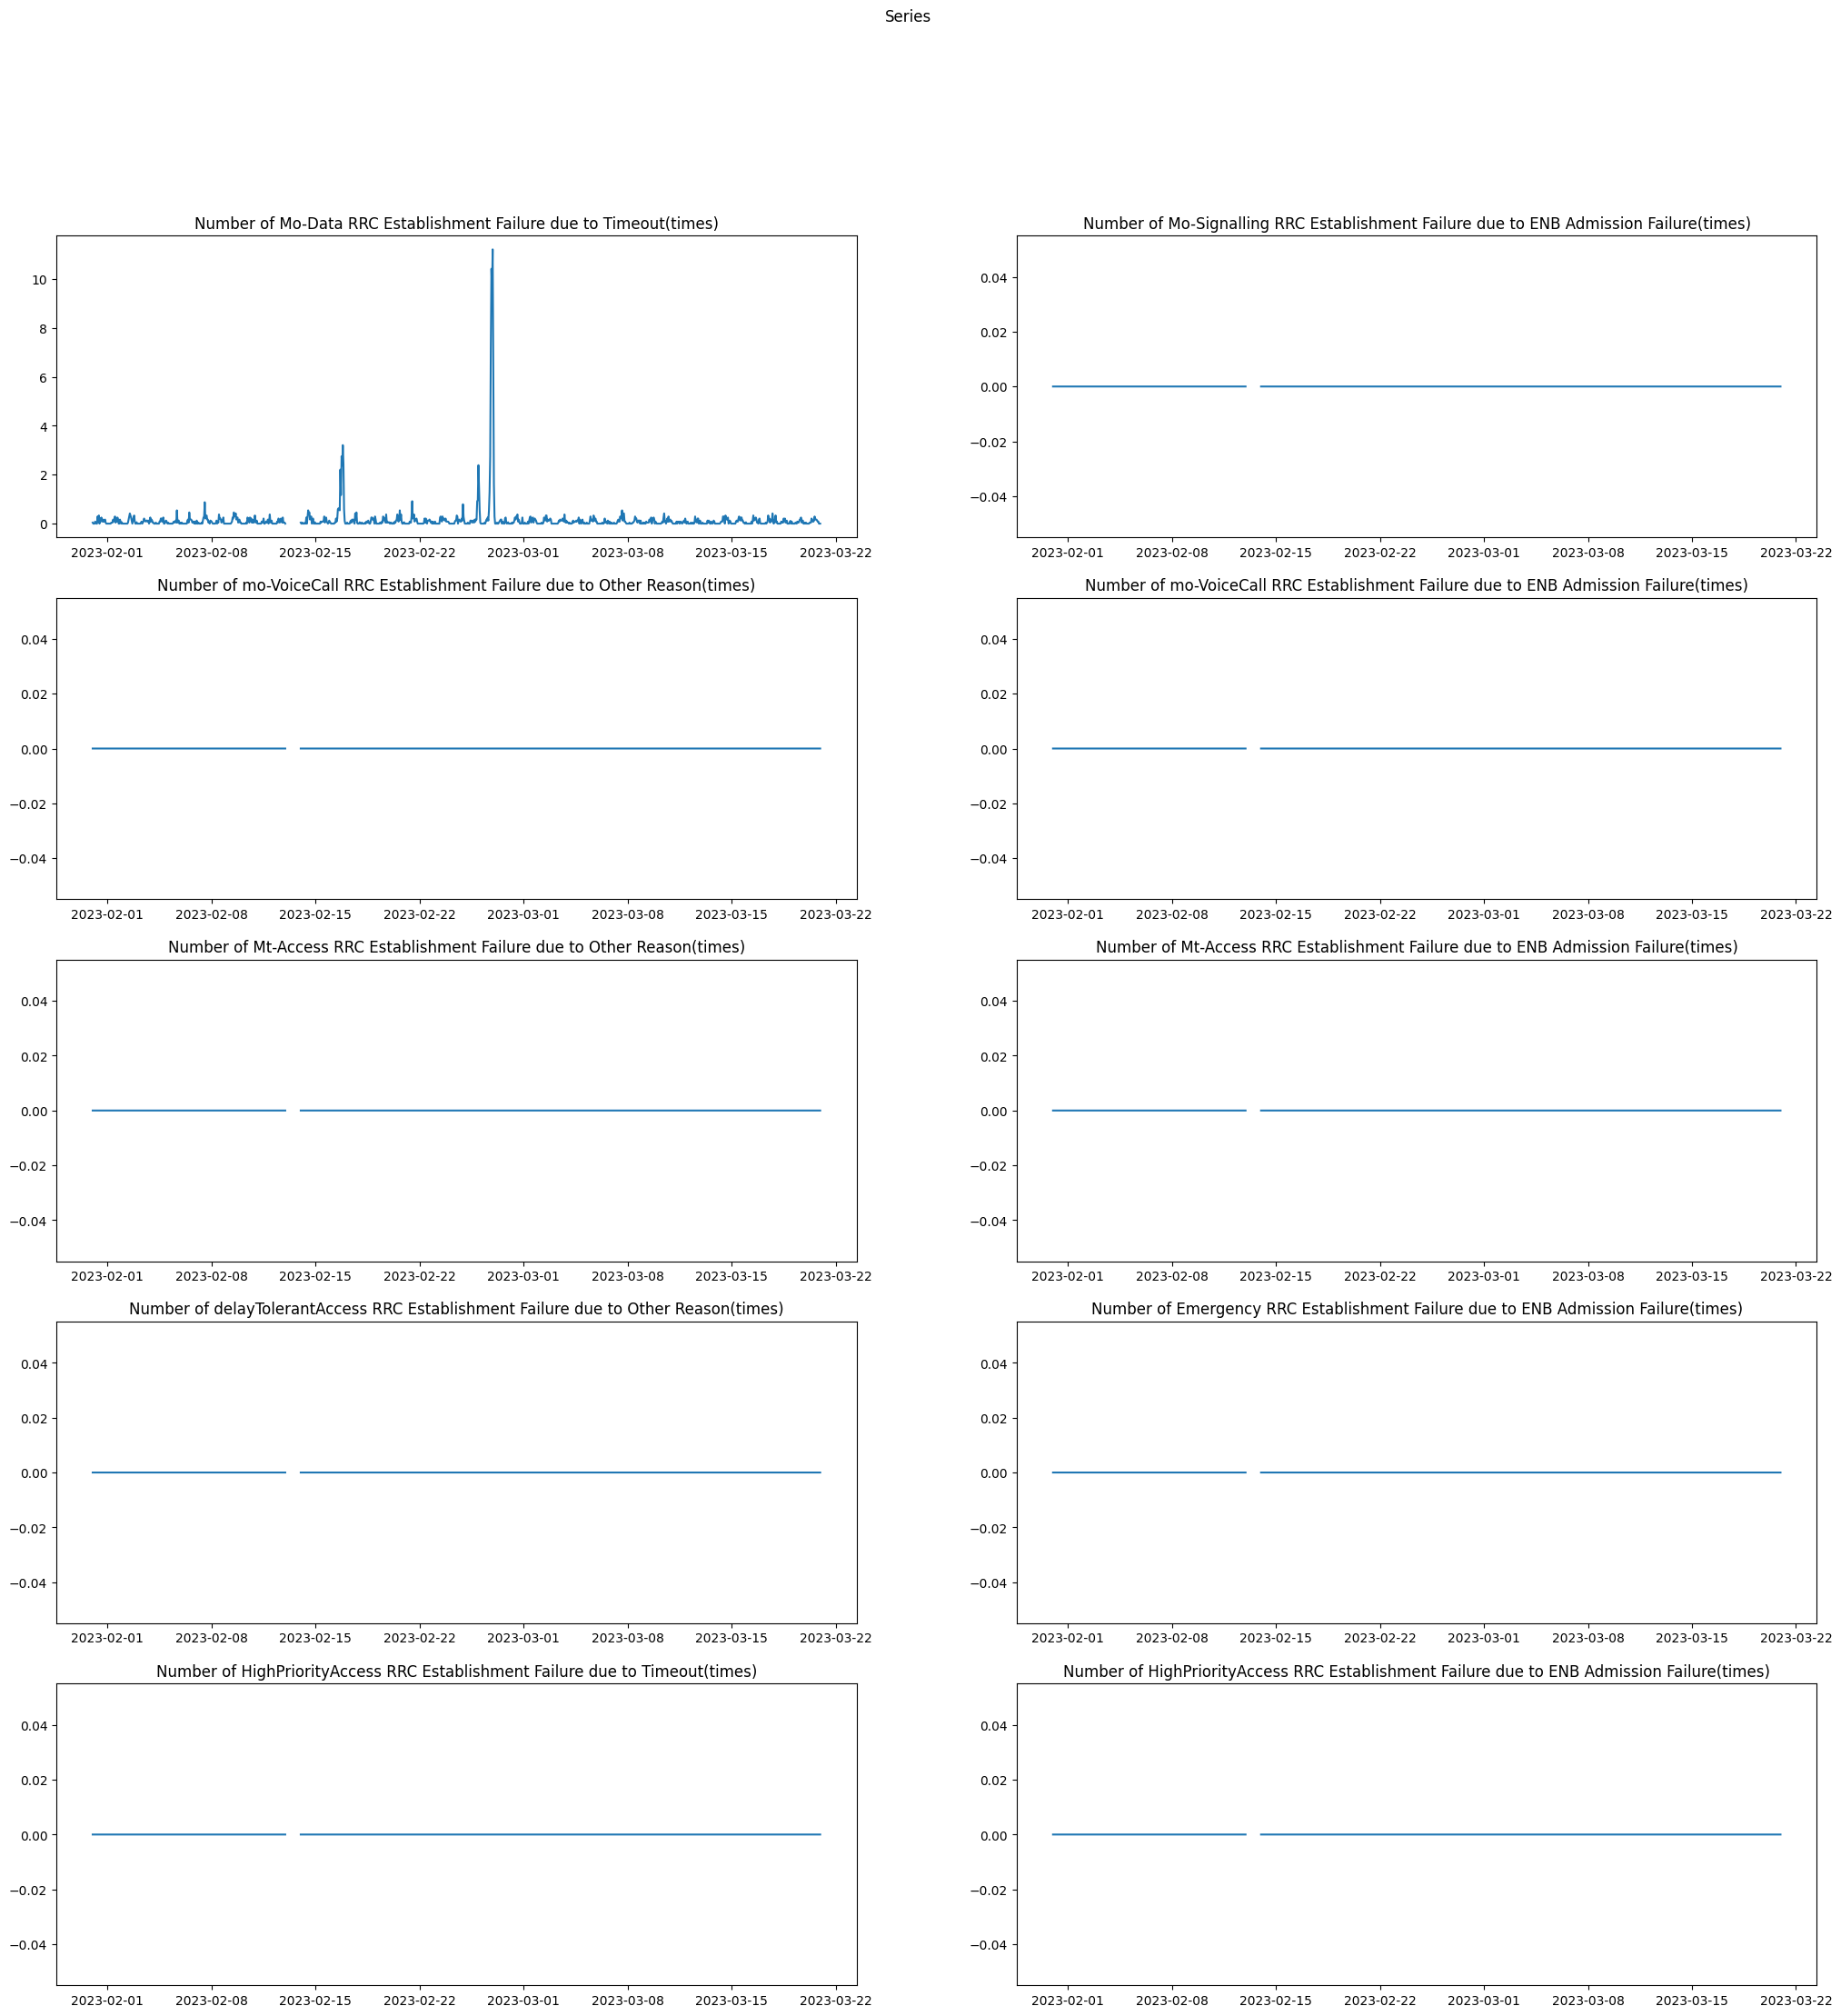

<Axes: xlabel='datetime'>

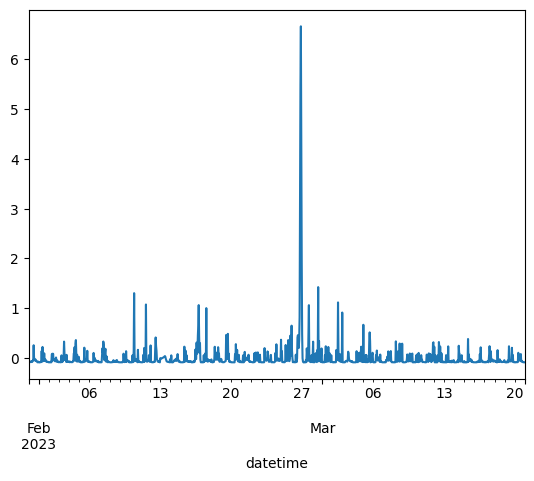

In [1013]:
import re

def find_values(array, pattern):
    matching_values = []
    not_matching_values = []

    for item in array:
        if isinstance(item, str) and re.search(pattern, item):
            matching_values.append(item)
        else:
            not_matching_values.append(item)

    return matching_values, not_matching_values

# Example
pattern_fl_times = r"(Number of)(.)*(Failure)(.)*\(unit\)"
pattern_fl_unit = r"(Number of)(.)*(Failure)(.)*\(times\)"
pattern_fl = r"(Number of)(.)*(Failure)(.)*"

#### without Filling NA
site_df = dsbysite.loc[dsbysite['SiteCode'] == 'LIM003'].copy()
site_df = site_df.drop('SiteCode', axis=1)

failure_metrics, kpis_metrics =find_values(site_df.columns,pattern_fl)
failure_metrics_unit, failure_metrics_times =find_values(failure_metrics,pattern_fl_times)
kpis_metrics.remove('incident')

print("kpis_metrics:{}, failure_metrics: {} = {}+{}".format(len(kpis_metrics), len(failure_metrics), len(failure_metrics_unit), len(failure_metrics_times)))

plotMultipleMetrics(site_df[failure_metrics_times],2,5)
#fl_df['Sum'] = fl_df.sum(axis=1)
fl_df['Mean'] = fl_df.mean(axis=1)
fl_df['Mean'].plot()
#print(failure_metrics_times)

(1176, 14)


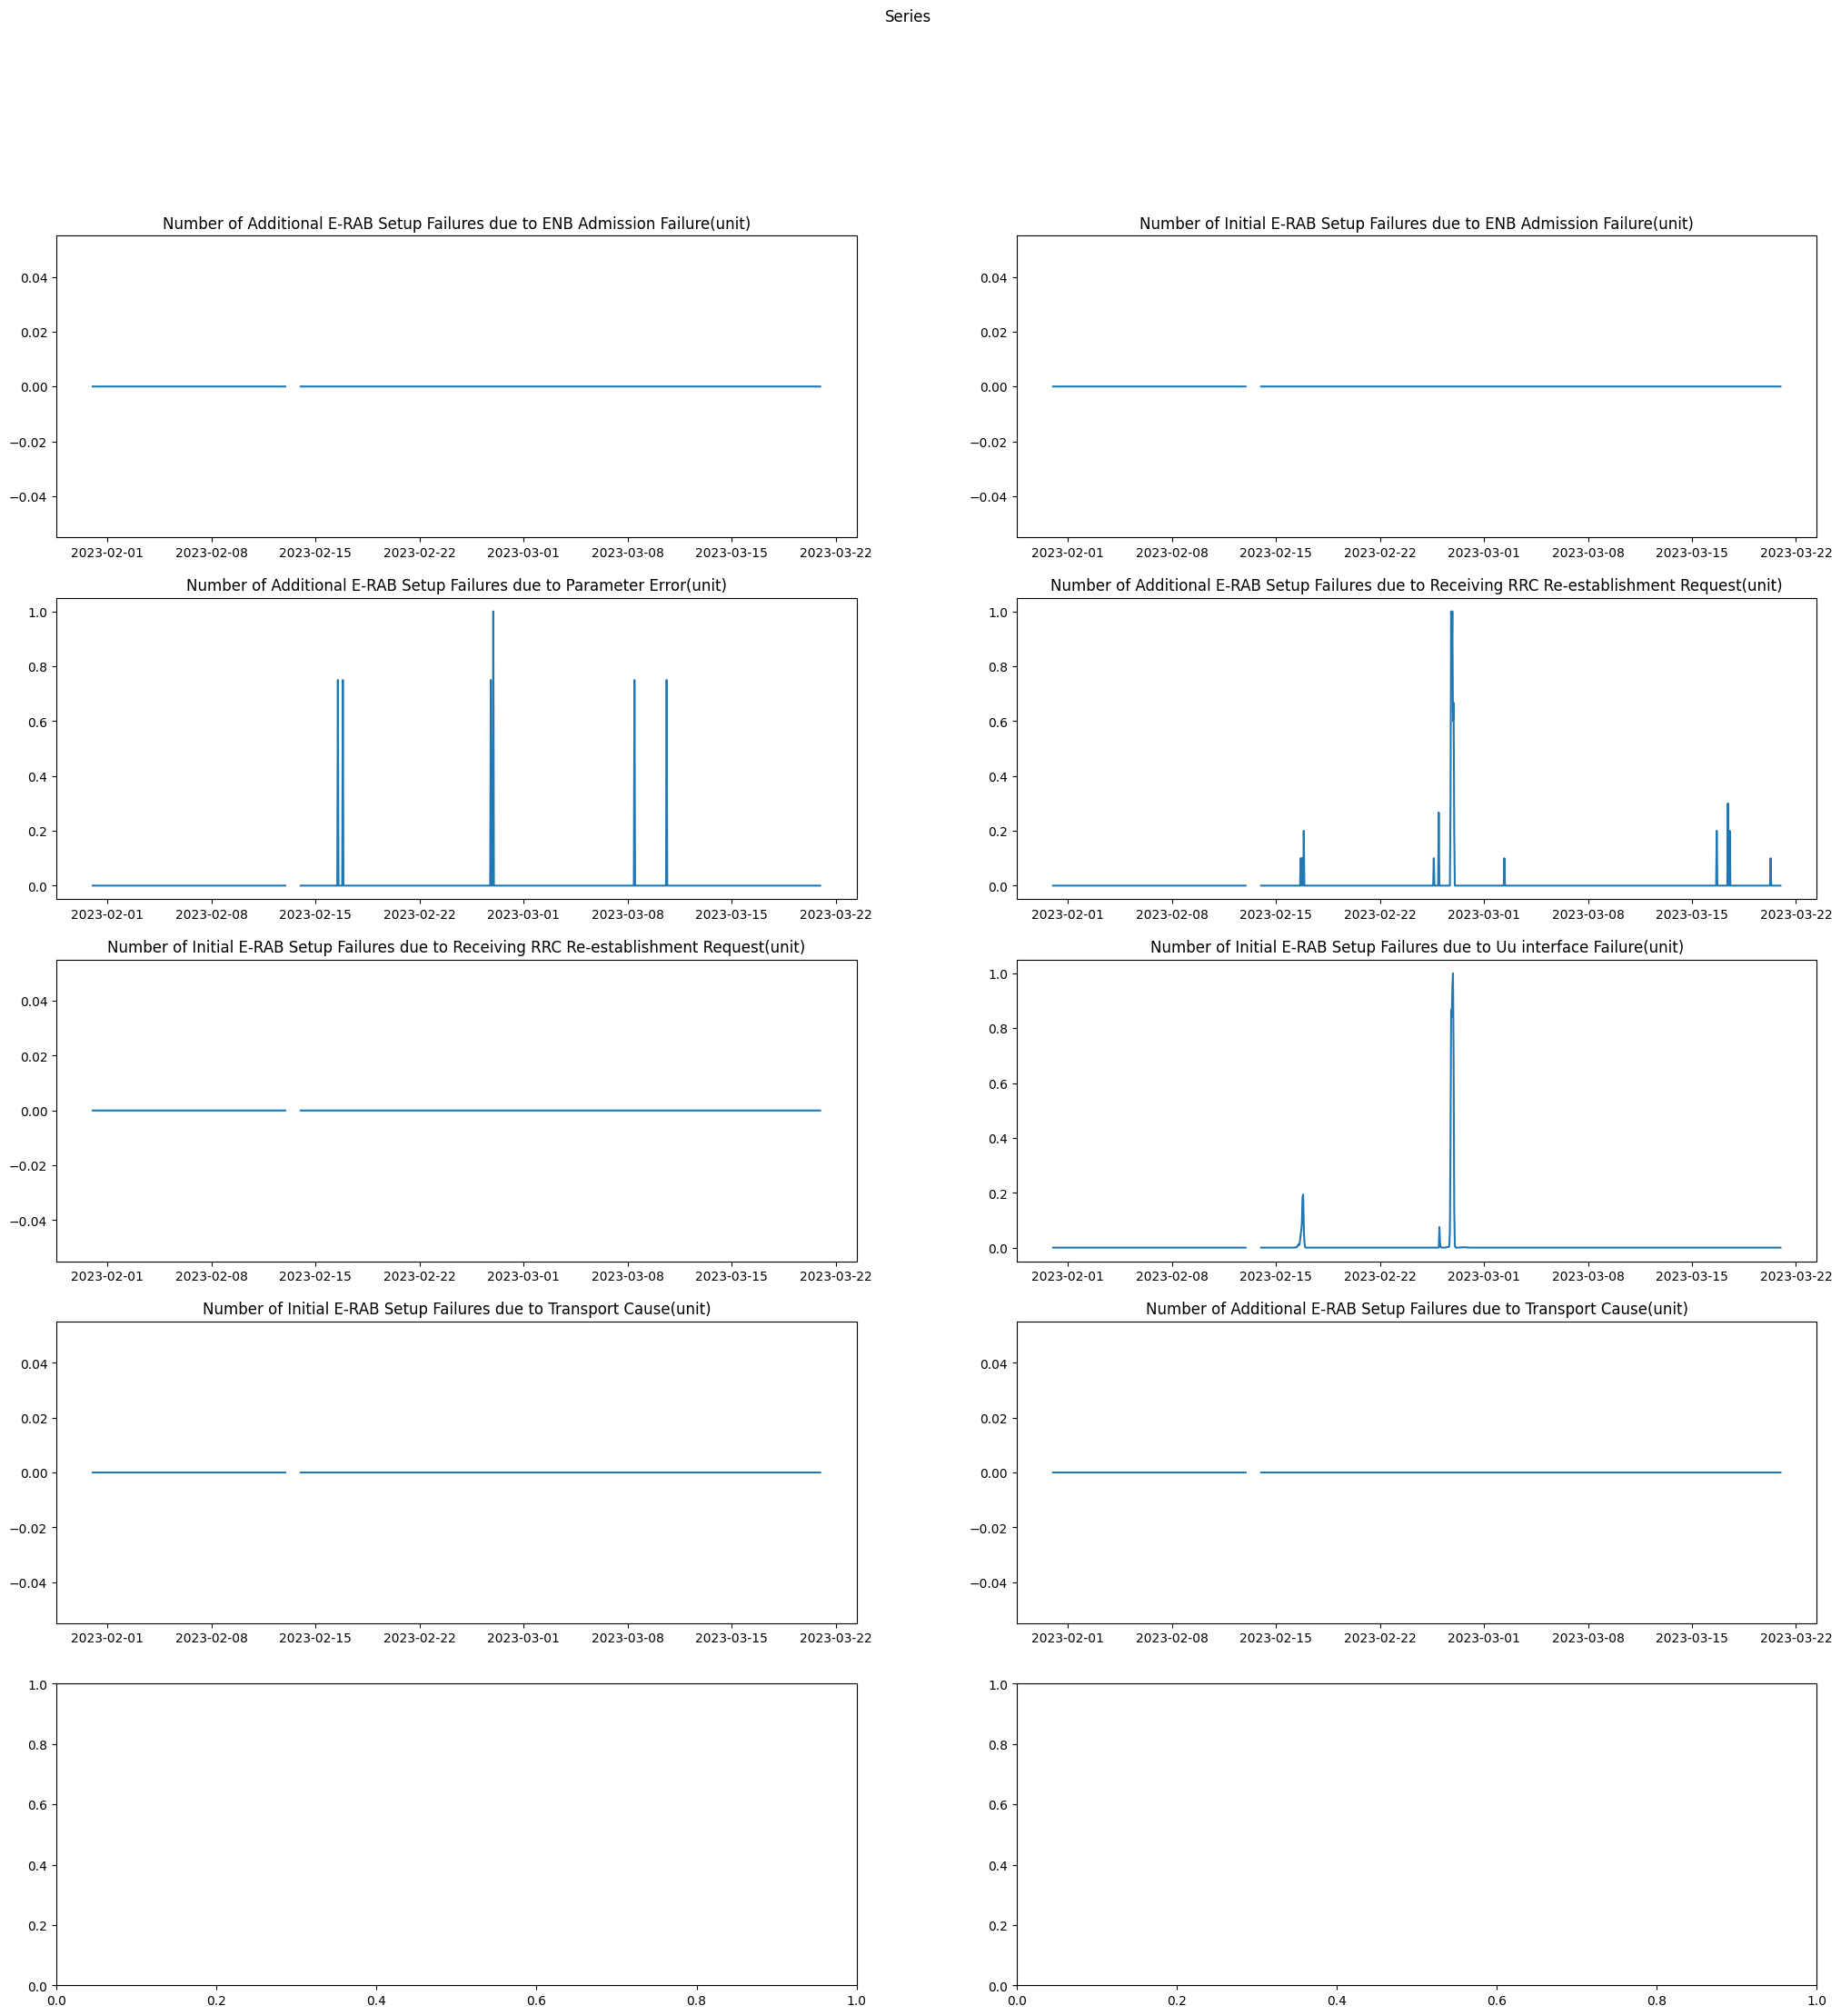

<Axes: xlabel='datetime'>

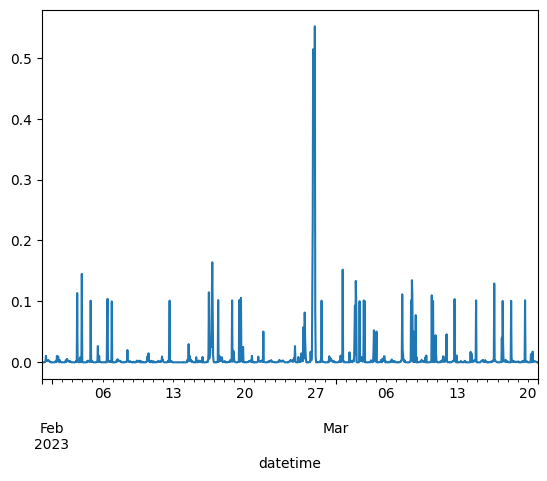

In [1014]:
fl_df = normalizedValues(site_df[failure_metrics_unit],MinMaxScaler((0, 1)))
print(fl_df.shape)
plotMultipleMetrics(fl_df,2,5)

fl_df['Sum'] = fl_df.sum(axis=1)
fl_df['Mean'] = fl_df.mean(axis=1)
fl_df['Mean'].plot()

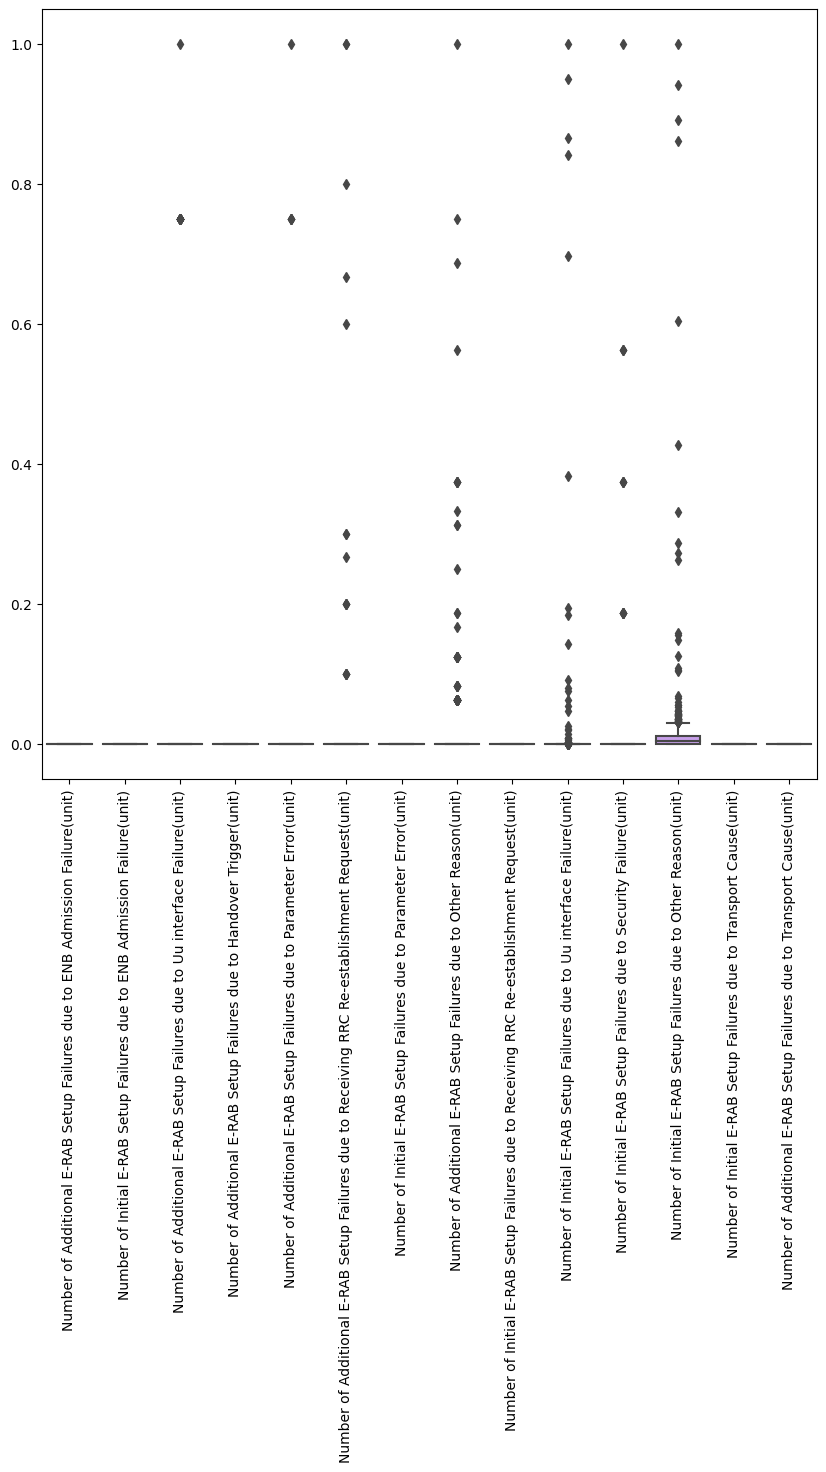

In [864]:
### Plot Outliers
import seaborn as sns # data visualization library  
plt_df = normalizedValues(site_df[failure_metrics_unit],MinMaxScaler((0, 1)))
plt.figure(figsize=(10,10))
sns.boxplot(data=plt_df)
plt.xticks(rotation=90)
plt.show()

## Filling Missing Values
#### Roaling Mean for 24 Hours

<Axes: xlabel='datetime'>

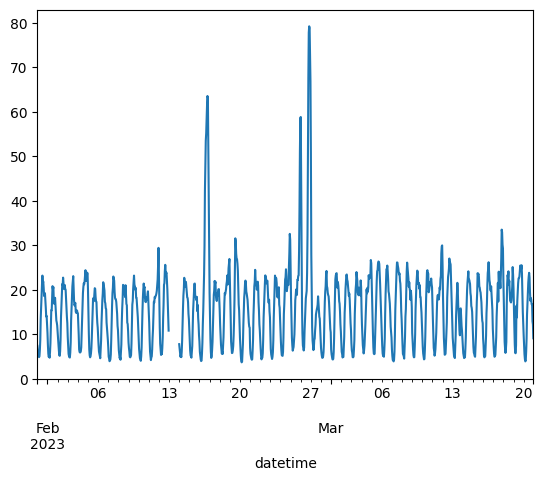

In [424]:
#### without Filling NA
site_df = dsbysite.loc[dsbysite['SiteCode'] == 'LIM003'].copy()
site_df = site_df.drop('SiteCode', axis=1)
#site_df[site_df.isnull().any(axis=1)].index
#.groupby([pd.Grouper(freq='D', level='datetime')]).mean()
site_df['Maximum Number of RRC Connection User(unit)'].plot()

0

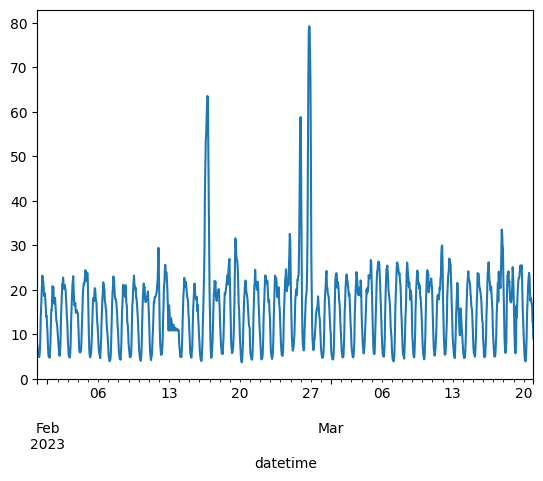

In [1300]:
#### without Filling NA
site_df = dsbysite.loc[dsbysite['SiteCode'] == 'LIM003'].copy()
site_df = site_df.drop('SiteCode', axis=1)
site_df = fillNa(site_df,6)
#site_df = rollingAvg(site_df,24)

#site_df[site_df.isnull().any(axis=1)].index
#.groupby([pd.Grouper(freq='D', level='datetime')]).mean()
site_df['Maximum Number of RRC Connection User(unit)'].plot()
#site_df = site_df.shift(5, freq='D')
#site_df['Maximum Number of RRC Connection User(unit)'].plot()

# Show the rows with NAN values
nan_rows = site_df[site_df.isnull().any(axis=1)]
nan_rows.shape[0]

## Data Observation
Apply features selections and observe the distribution of values

### VarianceThreshold and Correlation-based 
is a simple baseline approach to feature selection. It removes all features whose variance doesn’t meet some threshold. By default, it removes all zero-variance features, i.e. features that have the same value in all samples.
As an example, suppose that we have a dataset with boolean features, and we want to remove all features that are either one or zero (on or off) in more than 80% of the samples. Boolean features are Bernoulli random variables, and the variance of such variables is given by

(1176, 54)
(1176, 29)


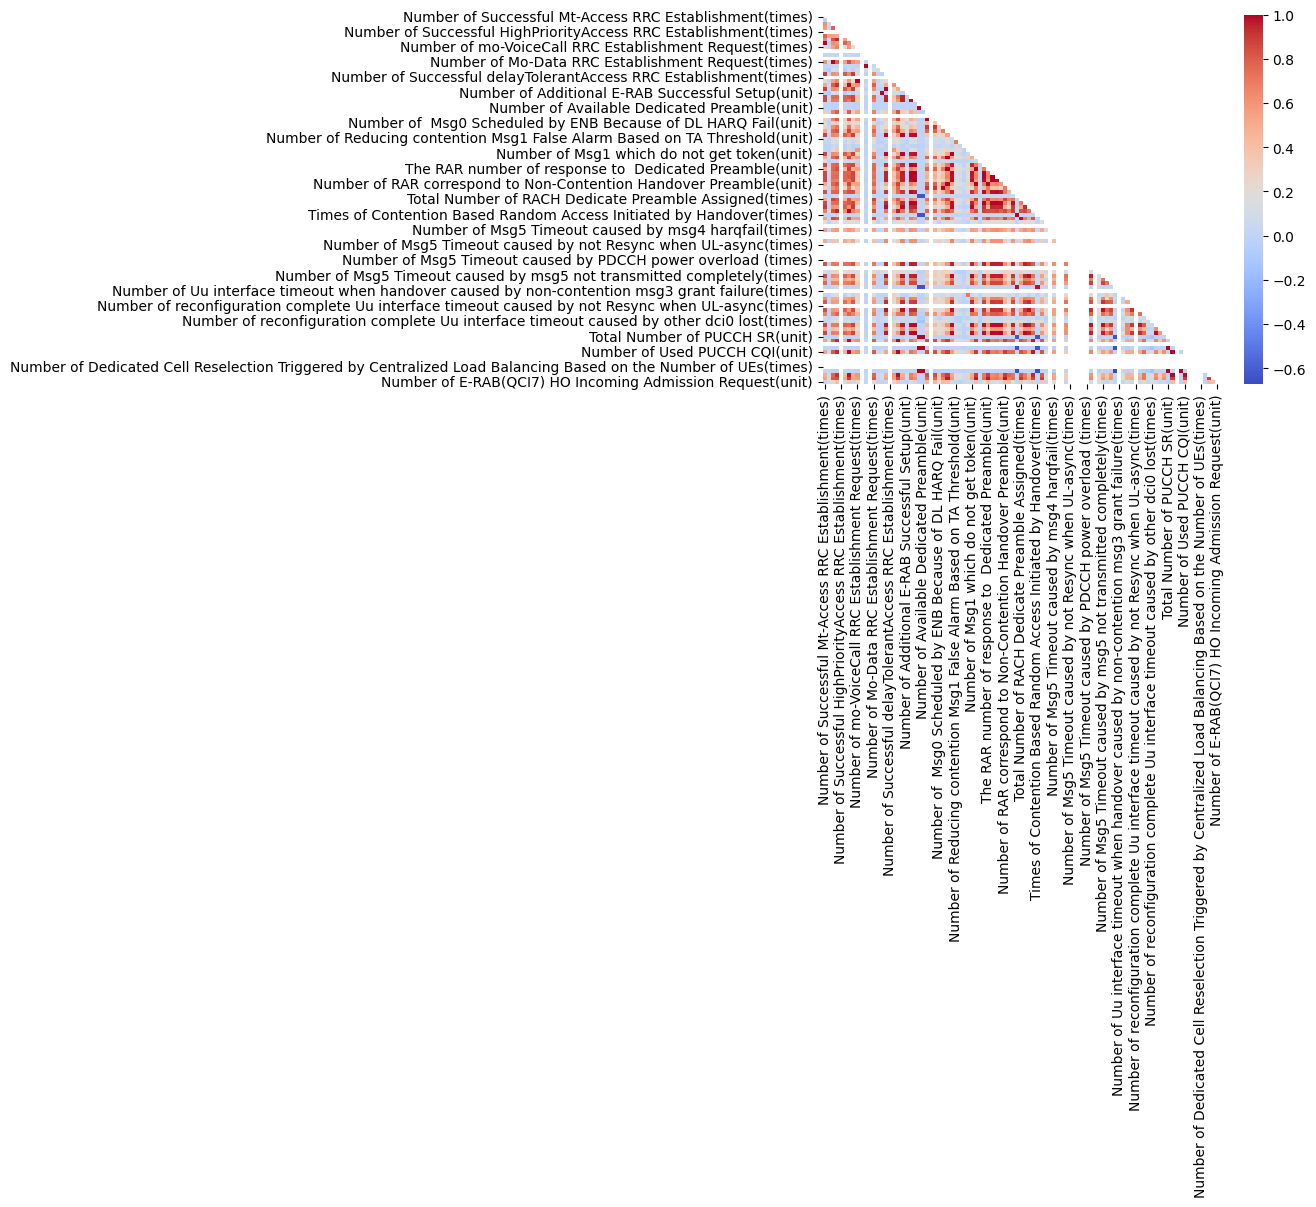

In [1302]:
site_df = dsbysite.loc[dsbysite['SiteCode'] == 'LIM003'].copy()
site_df = site_df.drop('SiteCode', axis=1)
site_df = site_df[kpis_metrics]
site_df = fillNa(site_df,24)

plot_corr_matrix(site_df)

site_df = remove_low_variance_features(site_df,0.05)
print(site_df.shape)
site_df = remove_high_corr_features(site_df,0.99)
print(site_df.shape)
#site_df = normalizedValues(site_df,StandardScaler()) # MinMaxScaler((0, 1)) )
#getMissingValues(site_df)

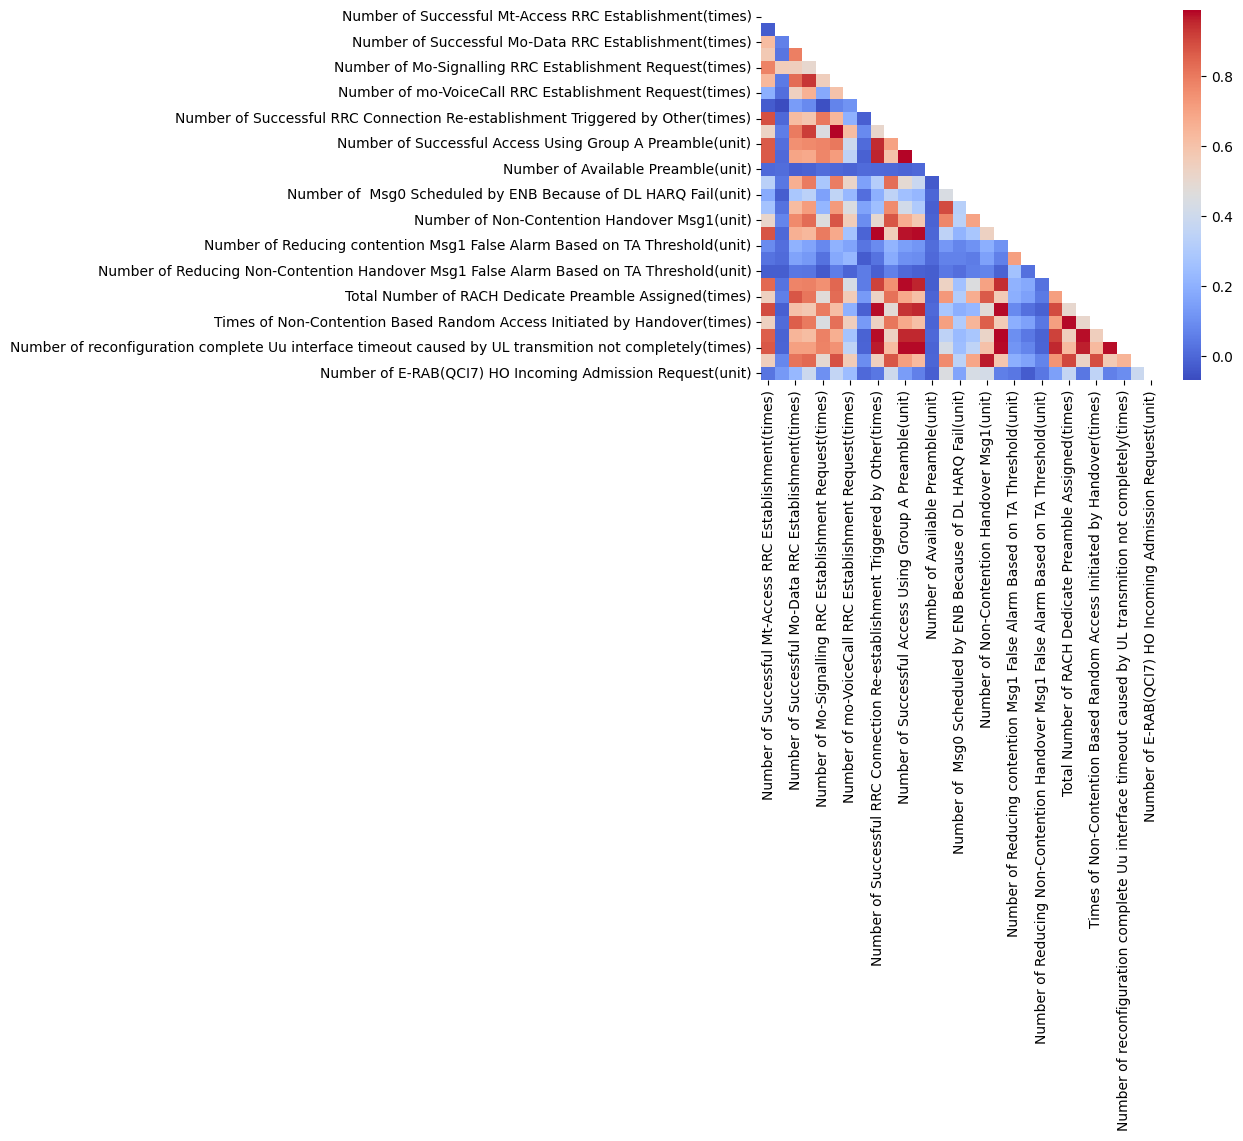

In [1303]:
## After 
plot_corr_matrix(site_df)

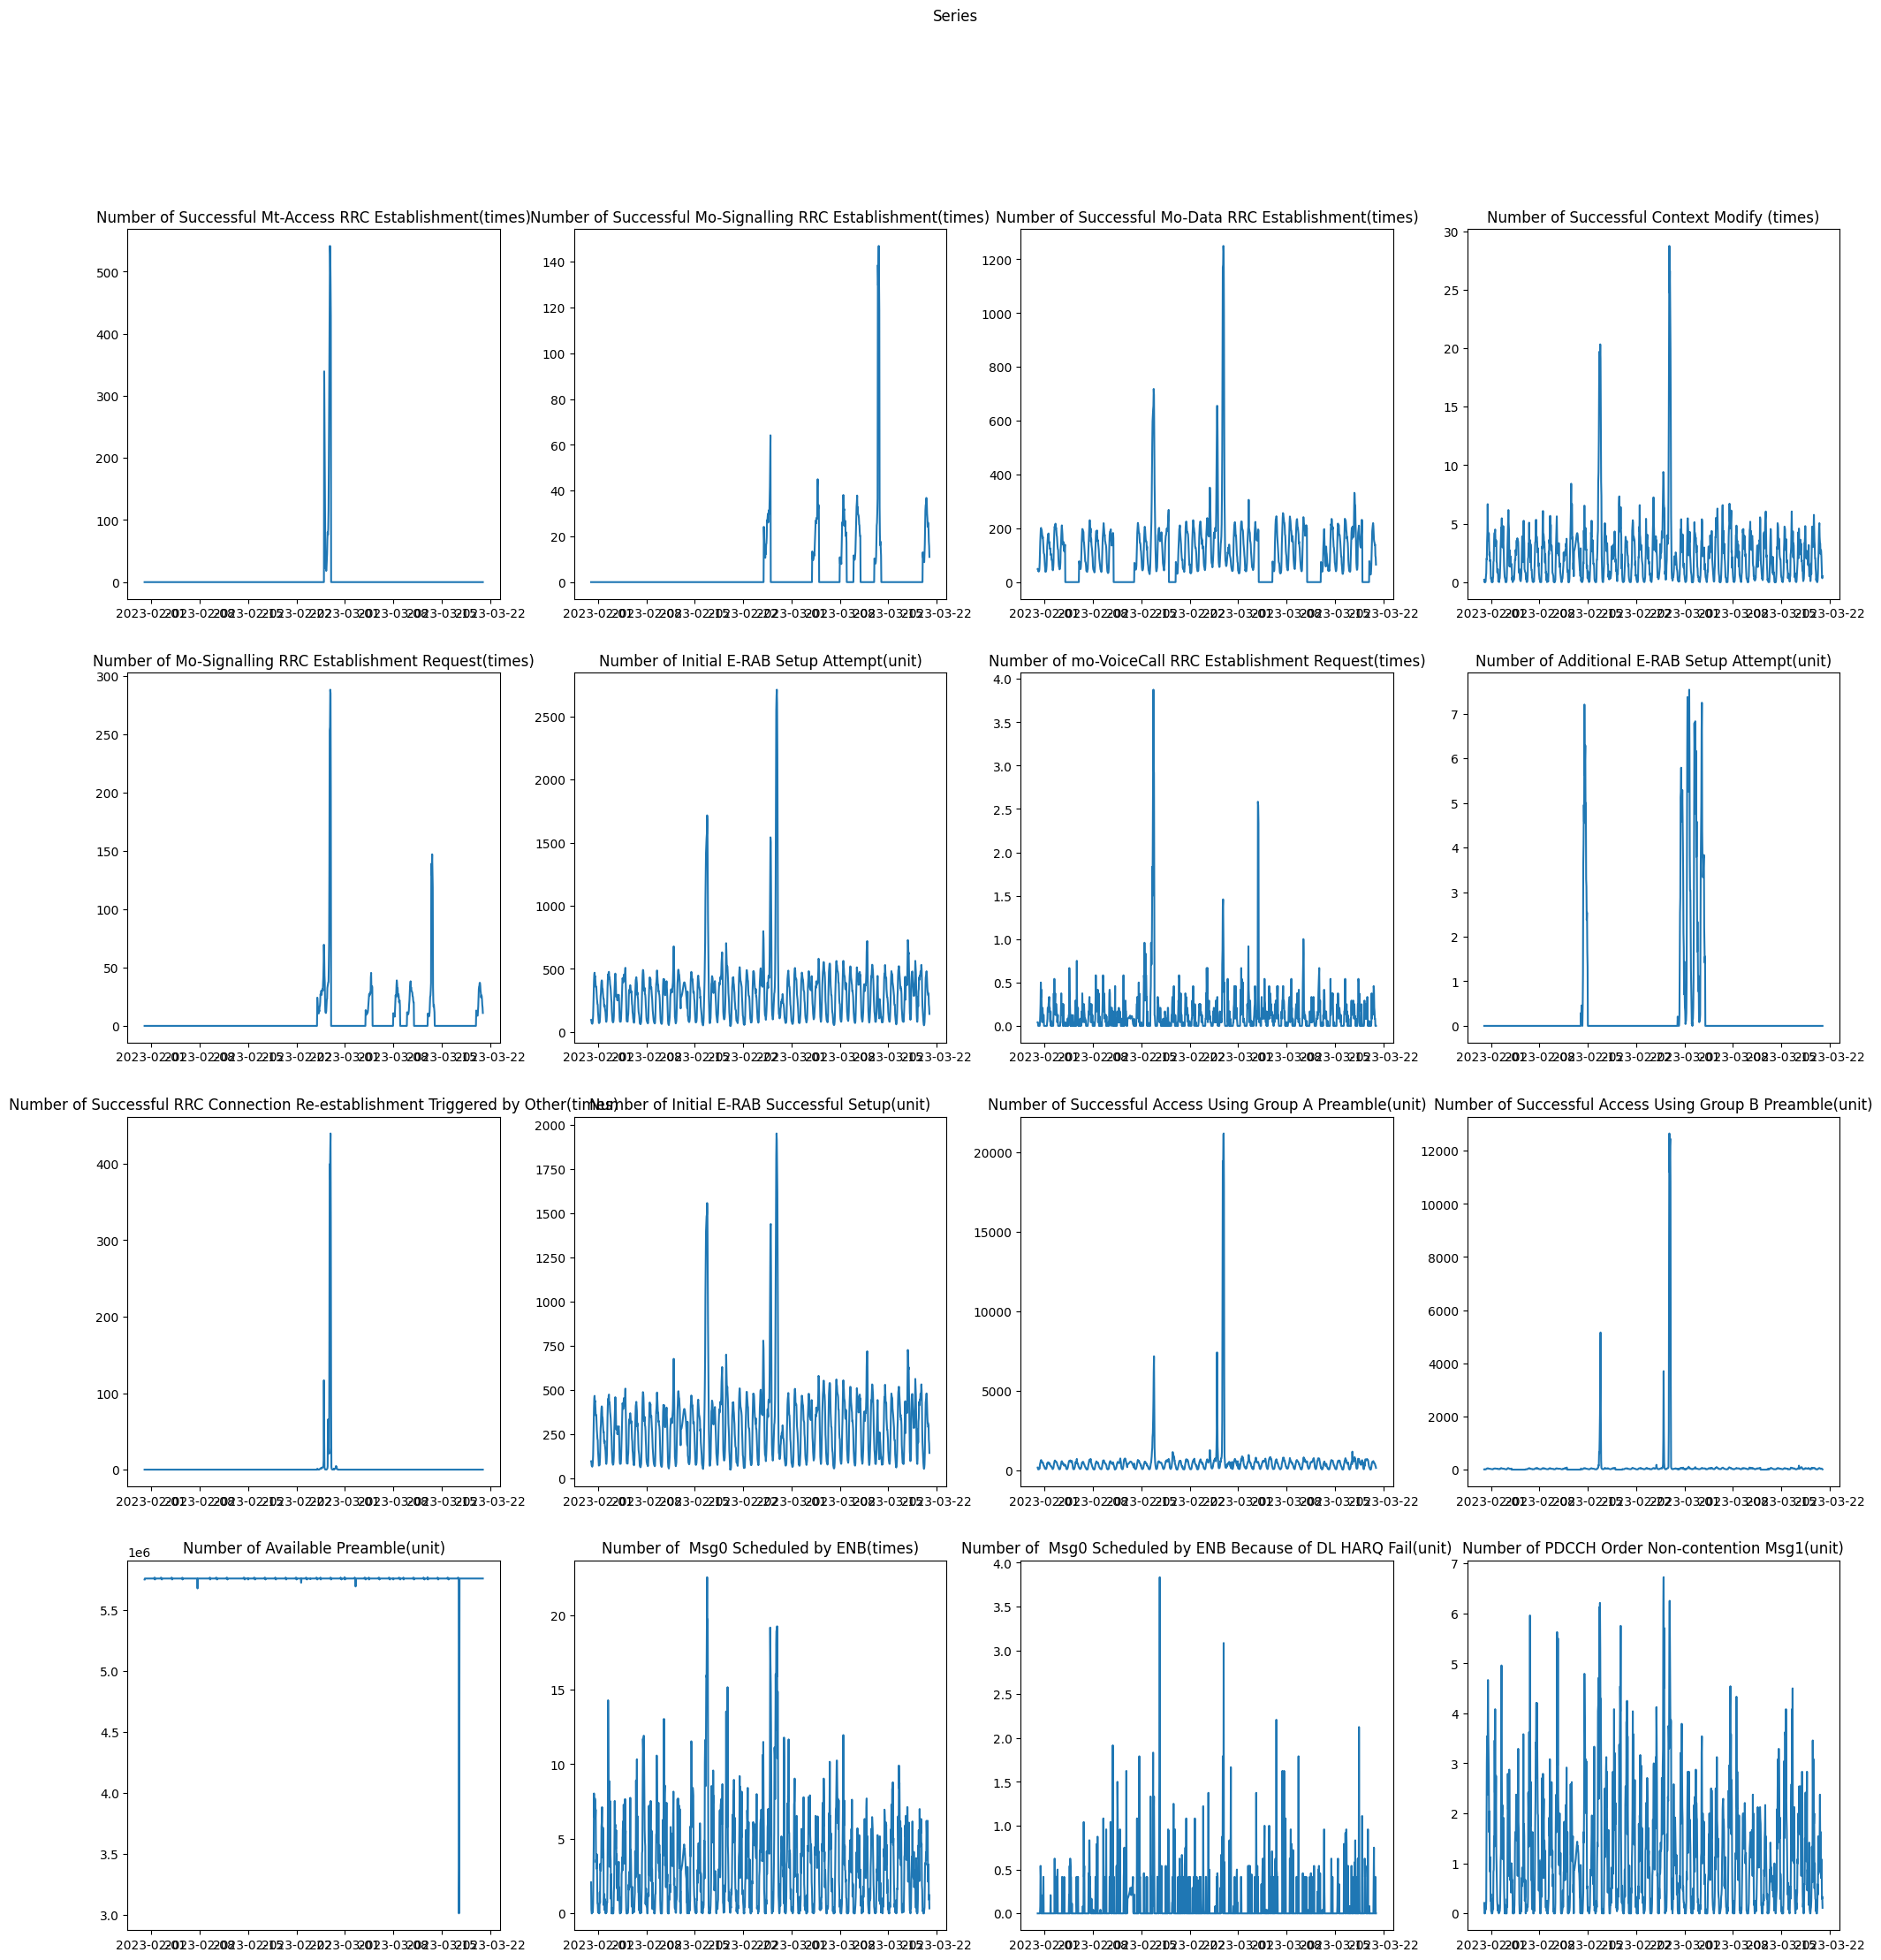

In [1304]:
plotMetrics(site_df,4,4)

### Decompose Time-Series to See Components (Trend, Seasonality, Noise, etc)

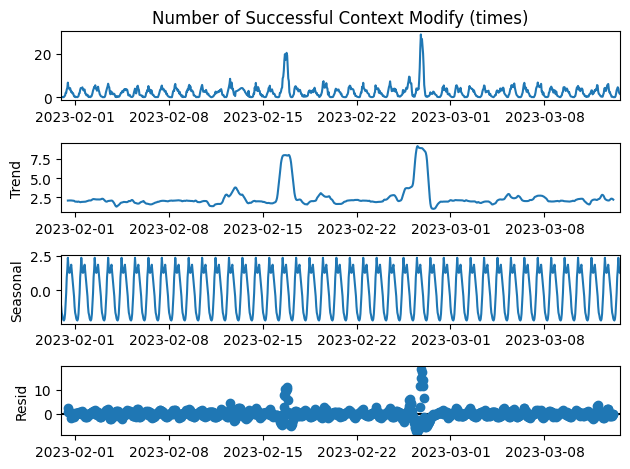

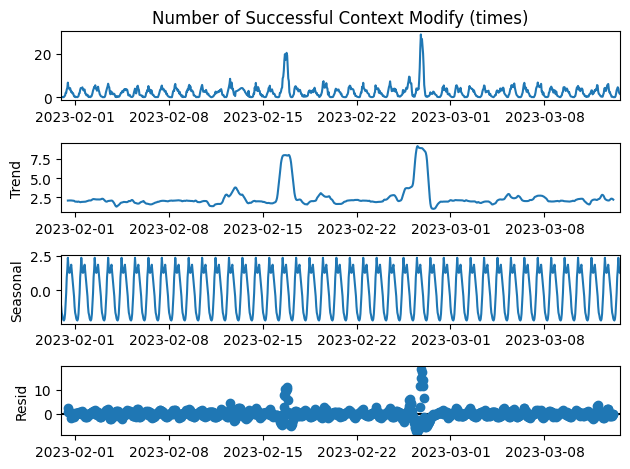

In [1318]:
from statsmodels.tsa.seasonal import seasonal_decompose
col = site_df.columns[3]
df_plot = site_df[col][:1000]

sd = seasonal_decompose(df_plot, model='additive', period=24)
sd.plot()

## DeTrend the data
Since we analyzing time series data, it is necessary to remove the trend component in order to focus on the underlying patterns and relationships in the data. This can be done using various methods, such as Moving average and Detrend function.

Moving average is a smoothing technique that involves computing the average of a fixed number of consecutive data points in the time series, and using this average as a replacement for the original values. The idea behind moving average is to reduce the noise or random fluctuations in the data, and to highlight the underlying trends or patterns. Moving average is often used as a pre-processing step for time series analysis, but it does not remove the trend component entirely.

Detrending, on the other hand, involves fitting a regression line to the time series data and subtracting this line from the data to obtain a detrended version of the series. The resulting series has the trend component removed, leaving only the residuals or deviations from the trend. Detrending is a more precise way to remove the trend component from the data, but it can also result in the loss of information if the trend component contains important information about the underlying patterns in the data.

In general, moving average is a simpler and less precise method for removing trends from time series data, and is often used for smoothing and pre-processing purposes. Detrending is a more sophisticated method that is better suited for time series analysis and hypothesis testing, but it requires more care and attention to ensure that important information is not lost in the process.

<Axes: >

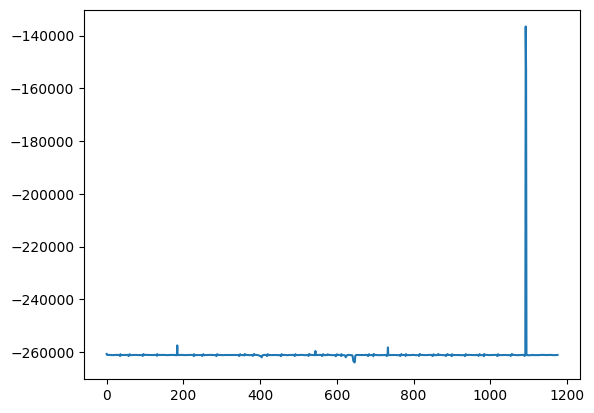

In [1323]:
# Remove trend from the data
from scipy.signal import detrend

col = site_df.columns[3]
site_df_detrended = pd.DataFrame(detrend(site_df), columns=site_df.columns)

site_df_detrended[col].plot()

In [1325]:
#We investigate the possibility to get the running mean for a window of 30-60-90 days \
#in order to make the distribution of values more linear
#As you increase the windows the average become more and more linear
import plotly.graph_objects as go
col = site_df.columns[3]
print(col)

df_plt = site_df[col][1:1000].copy()
#df_plt = df_plt.set_index('datetime')
#df_plt.index =  pd.DatetimeIndex(df_plt.index)
#df_plt = df_plt[col].resample('H').mean()

DateMVA1 = df_plt.rolling(window=24).mean()
DateMVA2 = df_plt.rolling(window=168).mean()

fig = go.Figure()
fig.add_trace(go.Scatter(x=df_plt.index, y=df_plt.values,
                    mode='lines',
                    name='Amount per Day')
             )

fig.add_trace(go.Scatter(x=DateMVA1.index, y=DateMVA1.values,
                    mode='lines',
                    name='Moving Average for 24 Hours')
             )

fig.add_trace(go.Scatter(x=DateMVA2.index, y=DateMVA2.values,
                    mode='lines',
                    name='Moving Average for 168 Hours')
             )


fig.show()

Number of Successful Context Modify (times)


# Split the Data and Fit the Models

In [1248]:
## the the datatime index and group the data by hour
def splitData(df, train_pct = 0.7):
    # get the unique dates from the index
    unique_days = pd.Series(df.index.date).unique()
    
    # calculate the number of rows for the training set
    train_size = int(len(unique_days) * train_pct)
    print(train_size)
        
    # calculate the end time of the training set
    train_end_time = df.index.min() + pd.Timedelta(train_size, unit="d")
    print(train_end_time)
    
    # separate the dataframe into training and testing sets
    train_df = df.loc[:train_end_time]
    test_df = df.loc[train_end_time + pd.Timedelta(hours=1):]
    
    return train_df,test_df

def getdata(df,sitecode,fillNa_p=24, scaler = StandardScaler(), detrendby='detrend',rolling_window=24, metrics ='All', failure_metrics = None):
    """
    Provide a new dataframe with data and labels according to the parameters that you can provide

    Args:
        df (pandas.DataFrame): The input DataFrame.
        sitecode: The input DataFrame.
        fillNa_p: The window of time that used for roaling avg to fill NAs
        scaler: The value scalre model [StandardScaler() or MinMaxScaler((0, 1))]
        detrendby: The Detrend method [detrend,rolling]
        rolling_window: The number of time window in case of Detrend by rolling
        metrics(list): The list of features that need to return 
    Returns:
        dfdata(pandas.DataFrame): The final dataset that could be used for model fiting
        dfdata_label(pandas.DataFrame): The lable (target) of this dataset that could be used for model fiting
    """
    
    dfdata = dsbysite.loc[df['SiteCode'] == sitecode].copy()
    dfdata = dfdata.drop('SiteCode', axis=1)
    
    dfdata_label = dfdata['incident']
    dfdata_label = dfdata_label.reset_index().set_index('datetime').fillna(False)
    dfdata = dfdata.drop('incident', axis=1)

    ##############################################################
    dfdata = fillNa(dfdata,fillNa_p)
    dffailure_metrics = dfdata.copy()
    
    if(metrics != 'All'):
        dffailure_metrics =normalizedValues(dfdata[failure_metrics],scaler)
        dffailure_metrics['Mean'] = dffailure_metrics.mean(axis=1)
        dfdata = dfdata[metrics]

    ##############################################################
    dfdata = remove_low_variance_features(dfdata,0.05)
    print(dfdata.shape)
    dfdata = remove_high_corr_features(dfdata,0.999)
    print(dfdata.shape)

    dfdata = normalizedValues(dfdata,scaler) 
    ##############################################################
    
    
    if(detrendby == 'detrend'):
        col = site_df.columns[5]
        dfdata_detrended = pd.DataFrame(detrend(dfdata), columns=dfdata.columns)
        dfdata_detrended['datetime'] = dfdata.index
        dfdata_detrended = dfdata_detrended.set_index('datetime')
        dfdata = dfdata_detrended.copy()

    elif(detrendby == 'rolling'):
        dfdata = rollingAvg(dfdata,rolling_window)
        
    ##############################################################
    
    return dfdata, dfdata_label, dffailure_metrics
 
    
    
def fit_model(df,n_estimators, contamination, maX_samples):
        
    # Initialize the Isolation Forest algorithm 
    #n_estimators is the number of trees in the forest
    #contamination is the expected proportion of outliers in the data.
    #the percentage of outliers to be detected
    # warm_start=True, 
    model = IsolationForest(n_estimators=n_estimators, contamination=contamination, maX_samples =maX_samples)
    #(random_state=42) 
    
    #n_neighbors is the number of nearest neighbors used to calculate the local density
    #contamination is the expected proportion of outliers in the data
    #model = LocalOutlierFactor(n_neighbors=n_estimators, contamination=outliers_fraction, novelty=True)
    
    # iterate over the groups and process each window separately
    print('############# Train #############')
    # Fit the model to the data
    model.fit(df.values)

    return model


def fit_model_by_window(df,n_estimators, contamination,maX_samples, n_window):
        
    model = IsolationForest(n_estimators=n_estimators, contamination=contamination)
    # define the time-series cross-validation iterator
    cv = TimeSeriesSplit(n_splits=n_window)

    # iterate over the folds and compute the F1 score for each fold
    scores = []
    for i, (train_idx, test_idx) in enumerate(cv.split(dfdata)):
        # split the data into training and test sets
        #X_train, X_test = dfdata.iloc[train_idx], dfdata.iloc[test_idx]
        X_train = dfdata.iloc[train_idx]

        # fit the model to the training data
        model.fit(X_train.values)

    return model


def predict(model,df):
    df= df.copy()
    # iterate over the groups and process each window separately
    print('############# Predict #############')

    # Predict the outliers using the trained model
    outliers = model.predict(df.values)
    X_scores = -model.decision_function(df.values)

    # Add the outlier predictions to the original data as a new column
    df['outliers'] = outliers
    df['scores'] = X_scores
    
    # compute the average path length (APL) for each instance in the data
    X_scores /= model.max_samples_
    X_scores = np.exp(X_scores.mean())
    fscore = f1_score(np.ones(len(outliers)), outliers, pos_label=-1, zero_division=1)
    print("Average path length (APL):{}, F1_Score:{}".format(X_scores,fscore))  
        
    return df


def fit_predict(df,n_estimators, outliers_fraction):
    df= df.copy()
    
    # Set the percentage of outliers to be detected
    estimators=n_estimators

    # Initialize the Isolation Forest algorithm 
    # warm_start=True, 
    #model = IsolationForest(n_estimators=estimators, contamination=outliers_fraction)
    # fit the model for outlier detection (default)
    model = LocalOutlierFactor(n_neighbors=n_estimators, contamination=outliers_fraction)
    
    # use fit_predict to compute the predicted labels of the training samples
    # (when LOF is used for outlier detection, the estimator has no predict,
    # decision_function and score_samples methods).
    outliers = model.fit_predict(df.values)
    #n_errors = (y_pred != ground_truth).sum()
    X_scores = model.negative_outlier_factor_
       
    df['outliers'] = outliers
    df['scores'] = X_scores

    return df 

def plot_resuls(df,outliers,incident,col):
    print(col)
    fig, ax = plt.subplots(figsize=(10,6))
    ax.plot(df.index, df[col], color='blue', label = 'Normal')
    ax.scatter(outliers.index,outliers, color='black', label = 'Anomaly')
    ax.scatter(incident.index,incident, color='red', label = 'Incident')
    plt.title(col)
    plt.legend()
    plt.show();
    return

In [1193]:
#incident['incident']
def find_boundaries(df, variable,q1=0.01,q2=0.99):
    # the boundaries are the quantiles
    lower_boundary = df[variable].quantile(q1) # lower quantile
    upper_boundary = df[variable].quantile(q2) # upper quantile
    return upper_boundary, lower_boundary

def flag_outliers(df,variable,q1=0.01,q2=0.99):
    outlier = df.copy()
    upper_boundary,lower_boundary =  find_boundaries(df,variable,q1,q2)
    #print('{}-{}'.format(upper_boundary,lower_boundary))
    outlier['outlier'] = (outlier[variable] < lower_boundary)|(outlier[variable] > upper_boundary)
    return outlier

def get_outliers(df,variable,q1=0.01,q2=0.99):
    outlier = df.copy()
    upper_boundary,lower_boundary =  find_boundaries(df,variable,q1,q2)
    #print('{}-{}'.format(upper_boundary,lower_boundary))
    outlier  = outlier.loc[(outlier[variable] < lower_boundary)|(outlier[variable] > upper_boundary)]
    #outlier[variable] = np.where(outlier[variable] > upper_boundary, upper_boundary,
    #                   np.where(outlier[variable] < lower_boundary, lower_boundary, outlier[variable]))
    return outlier


# Explore the relationships between variables and identify potential causal factors

Use Granger causality analysis, which is a statistical method that examines whether one time series variable can be used to predict another time series. This method can be used to determine whether there is a causal relationship between two time series, and to identify the direction of causality.

When exploring the relationships between time series data and global issues, it can also be useful to consider other contextual factors that may be driving the observed correlations. For example, changes in economic conditions or political factors may be influencing both the global issue and the time series data, and failing to account for these factors can lead to spurious correlations or incorrect causal inferences.

- "ssr based F test" A low F-value and a high p-value (usually > 0.05) indicate no significant causal relationship.
- "likelihood ratio test": This column shows the results of the likelihood ratio test, which compares the likelihood of the restricted model to the likelihood of the unrestricted model. The test is based on the log-likelihood ratio, and a high chi-squared value and a low p-value (usually < 0.05) indicate a significant causal relationship.    
- The test is based on the log-likelihood ratio, and a high chi-squared value and a high p-value (usually > 0.05) indicate no significant causal relationship.

### We execute a this Causality Test for all compination varables with max leg 5

In [1568]:
from statsmodels.tsa.stattools import grangercausalitytests

dfdata, incident, fl_df = getdata(dsbysite, 'LIM003', 24, StandardScaler(),'detrend',24,kpis_metrics,failure_metrics)  
dfdata['FalureKPIsMean'] = fl_df['Mean']

(1176, 54)
(1176, 37)


In [1569]:
lst = []
maxlag = 6

for a in  dfdata.columns:
    cols = [a,'FalureKPIsMean']
    results = grangercausalitytests(dfdata[cols], maxlag=maxlag, verbose=False)
    pvalue_lag = []
    for i in range(maxlag):
        lag = results[i+1][0]["ssr_ftest"][1]
        pvalue_lag.append(lag)
        
    var = [cols[0],cols[1]] #.extend(pvalue_lag)
    var.extend(pvalue_lag)
    lst.append(var) 
    
lables = ['var1','var2']
for i in range(maxlag):
    lables.extend(['pvalue_lag'+str(i+1)])

df = pd.DataFrame(lst, columns=lables)
df.head(5)

,var1,var2,pvalue_lag1,pvalue_lag2,pvalue_lag3,pvalue_lag4,pvalue_lag5,pvalue_lag6
0,Number of Successful Mt-Access RRC Establishme...,FalureKPIsMean,0.010401,1.286785e-10,3.377064e-22,1.602406e-31,1.141719e-32,2.619156e-37
1,Number of Successful Mo-Signalling RRC Establi...,FalureKPIsMean,0.416334,1.327053e-08,3.835542e-09,4.864243e-08,1.257761e-07,2.254336e-09
2,Number of Successful Mo-Data RRC Establishment...,FalureKPIsMean,0.016170,8.248351e-04,1.056628e-04,5.608692e-04,1.028580e-03,7.381531e-04
3,Number of Successful Context Modify (times),FalureKPIsMean,0.137022,4.399448e-01,2.905037e-01,4.825705e-02,7.921786e-02,1.325863e-02
4,Number of Mo-Signalling RRC Establishment Requ...,FalureKPIsMean,0.236827,1.148845e-02,2.639919e-12,1.126564e-15,2.209277e-15,4.917063e-25


In [1570]:
for i in range(maxlag):
    label = 'pvalue_lag'+str(i+1)
    print('Number of Variable with p-value < 0.05 for lag {} is: {}'.format(i+1,df.loc[df[label] < 0.05].shape[0]/df.shape[0]))


Number of Variable with p-value < 0.05 for lag 1 is: 0.6052631578947368
Number of Variable with p-value < 0.05 for lag 2 is: 0.7368421052631579
Number of Variable with p-value < 0.05 for lag 3 is: 0.8947368421052632
Number of Variable with p-value < 0.05 for lag 4 is: 0.9473684210526315
Number of Variable with p-value < 0.05 for lag 5 is: 0.9473684210526315
Number of Variable with p-value < 0.05 for lag 6 is: 0.9736842105263158


In [1347]:
# Shift the data for lag = 5 and fill the nulls 
lag = 5
fl_df['Mean'].shift(lag).fillna(method='bfill').head(10)

datetime
2023-01-31 00:00:00   -0.023216
2023-01-31 01:00:00   -0.023216
2023-01-31 02:00:00   -0.023216
2023-01-31 03:00:00   -0.023216
2023-01-31 04:00:00   -0.023216
2023-01-31 05:00:00   -0.023216
2023-01-31 06:00:00   -0.052779
2023-01-31 07:00:00   -0.056418
2023-01-31 08:00:00   -0.055422
2023-01-31 09:00:00   -0.053779
Name: Mean, dtype: float64

In [1589]:
df.loc[df[label] < 0.05].sort_values('pvalue_lag5').head(6)

kpis_metrics_causal_relationship = list(df.loc[df[label] < 0.05]['var1'].values)
print(len(kpis_metrics_causal_relationship))

37


In [1349]:
### the top lag5
a = df.sort_values('pvalue_lag5', ascending=True)['var1'][5:6].values
cols = [a[0],'FalureKPIsMean']
print(cols)
results = grangercausalitytests(dfdata[cols], maxlag=3)

for lag in results.keys():
    # p-value for each lag, which indicates the statistical significance of the causal relationship between the two time series.
    print(f'Lag {lag}: p-value = {results[lag][0]["ssr_ftest"][1]:.4f}')    

['Number of Reducing contention Msg1 False Alarm Based on TA Threshold(unit)', 'FalureKPIsMean']

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=129.2846, p=0.0000  , df_denom=1172, df_num=1
ssr based chi2 test:   chi2=129.6156, p=0.0000  , df=1
likelihood ratio test: chi2=122.9523, p=0.0000  , df=1
parameter F test:         F=129.2846, p=0.0000  , df_denom=1172, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=61.1856 , p=0.0000  , df_denom=1169, df_num=2
ssr based chi2 test:   chi2=122.8946, p=0.0000  , df=2
likelihood ratio test: chi2=116.8787, p=0.0000  , df=2
parameter F test:         F=61.1856 , p=0.0000  , df_denom=1169, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=42.2036 , p=0.0000  , df_denom=1166, df_num=3
ssr based chi2 test:   chi2=127.3710, p=0.0000  , df=3
likelihood ratio test: chi2=120.9187, p=0.0000  , df=3
parameter F test:         F=42.2036 , p=0.0000  , df_denom=1166, 

## Investigating Pamateres by Visualizing the results

(1176, 31)
(1176, 28)
Missing Values 0
34
2023-03-06 00:00:00
34
2023-03-06 00:00:00
y_test (4,)
############# Predict #############
Average path length (APL):0.9992653092953176, F1_Score:0.0
2023-03-20 23:00:00
['Number of Successful Mt-Access RRC Establishment(times)']


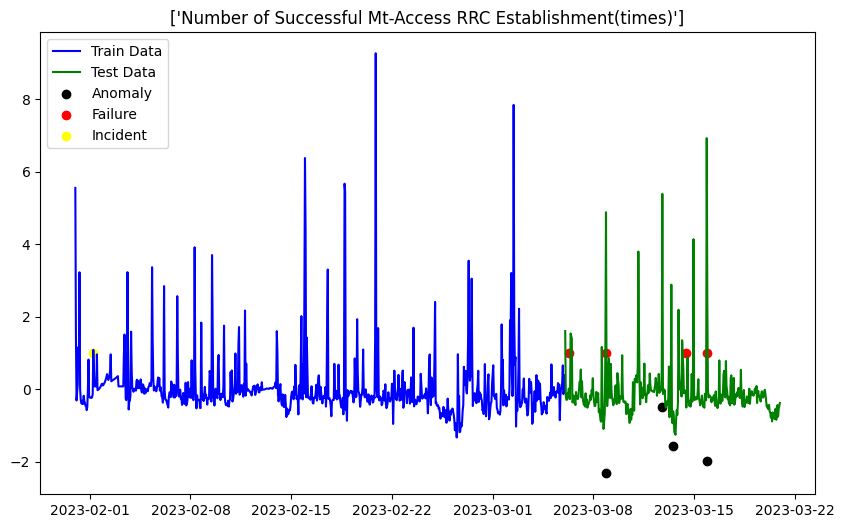

,Number of Successful Mt-Access RRC Establishment(times),Number of Successful Mo-Signalling RRC Establishment(times),Number of Successful Mo-Data RRC Establishment(times),Number of Successful Context Modify (times),Number of Mo-Signalling RRC Establishment Request(times),Number of Initial E-RAB Setup Attempt(unit),Number of mo-VoiceCall RRC Establishment Request(times),Number of Additional E-RAB Setup Attempt(unit),Number of Successful Access Using Group A Preamble(unit),Number of Successful Access Using Group B Preamble(unit),...,Total Number of RACH Dedicate Preamble Assigned(times),Number of Successful Msg3 Checked by ENB(times),Number of Successful Msg4 Checked by ENB(times),Times of Non-Contention Based Random Access Initiated by Handover(times),Number of Used PUCCH SR(unit),Maximum Number of RRC Connection User(unit),Number of E-RAB HO Incoming Admission Request(unit),Number of E-RAB(QCI7) HO Incoming Admission Request(unit),outliers,scores
datetime,,,,,,,,,,,,,,,,,,,,,
2023-03-13 13:00:00,-1.563187,6.153970,-1.755244,-1.063701,6.108370,-2.814084,-1.320442,-1.150512,-0.608189,-0.230523,...,0.115022,0.676469,1.249822,-0.576365,-0.093807,0.343077,0.371577,0.947814,-1,0.002500
2023-03-12 19:00:00,-0.487602,-0.703907,-1.978565,-0.022010,-0.807332,0.123639,0.200623,-0.803697,5.389085,-1.693465,...,-1.882068,-0.392310,-0.372322,-1.895310,0.583617,0.068014,-2.171216,-0.503380,-1,0.035324
2023-03-15 21:00:00,-1.981988,-2.167058,-1.036030,-2.072373,-2.176776,-1.620134,-2.176490,-2.079434,6.926638,1.893994,...,-1.233610,-1.401759,-1.139491,-1.449312,-1.012775,-1.146323,-1.714079,-2.433268,-1,0.055338
2023-03-08 21:00:00,-2.317822,0.139122,-1.631262,-2.458770,0.156398,-2.108930,-2.427827,-2.316688,4.882001,-1.082800,...,-1.600805,-1.826897,-1.618070,-1.678079,-1.846822,-1.630929,-1.779115,-2.033627,-1,0.091494


In [1596]:
dfdata, incident, fl_df = getdata(dsbysite, 'PAF024', 24, StandardScaler(),'detrend',24,kpis_metrics_causal_relationship,failure_metrics)  
#failure_metrics, kpis_metrics
#PAF024 LIM003

########################################################
print('Missing Values {}'.format(len(getMissingValues(dfdata))))
train_data,test_data = splitData(dfdata,0.7)

y_train,y_test = splitData(fl_df,0.7)
#y_train,y_test = y_train['Mean'].values,y_test['Mean'].values

# Obtain outlier scores and true labels
y_test = flag_outliers(y_test,'Mean')
y_test = y_test[y_test['outlier']==True]
y_test = y_test['outlier']
print('y_test',y_test.shape)


#########################################################
#model = fit_model(train_data,5, 0.02)
model = fit_model_by_window(train_data, 20,0.01, 0.75, 168)
#model = fit_model_by_window(train_data,5, 0.02,168)

#########################################################
#print(model.estimator_)
pred_data = predict(model,test_data)
print(max(pred_data.index))

#########################################################
## select the top
col = df.sort_values('pvalue_lag5')['var1'].head(1).values
#col = pred_data.columns[3]

#col = 'Maximum Number of RRC Connection User(unit)'
outliers = pred_data.loc[pred_data['outliers'] == -1, col] #anomaly
incident = incident.loc[incident['incident'] == True]

print(col)
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(train_data.index, train_data[top_var], color='blue', label = 'Train Data')
ax.plot(test_data.index, test_data[top_var], color='green', label = 'Test Data')
ax.scatter(outliers.index,outliers, color='black', label = 'Anomaly')
ax.scatter(y_test.index,y_test, color='red', label = 'Failure')
ax.scatter(incident.index,incident, color='yellow', label = 'Incident')
plt.title(col)
plt.legend()
plt.show();

#########################################################
# Filter the original data to only include the non-outliers
outliers = pred_data.loc[pred_data['outliers'] == -1]
outliers.sort_values('scores').head(5)

## Receiver Operating Characteristic (ROC) curve
The closer the ROC curve is to the top-left corner of the plot, the better the model's performance. A perfect classifier would have an ROC curve that passes through the top-left corner, representing a TPR of 1 and an FPR of 0. The area under the ROC curve (AUC-ROC) is a common metric used to quantify the overall performance of the model, with a value ranging from 0 to 1. A higher AUC-ROC indicates better discrimination between positive and negative samples.

(1176, 54)
(1176, 37)
34
2023-03-06 00:00:00
############# Predict #############
Average path length (APL):0.9989203690260572, F1_Score:0.0
2023-03-20 23:00:00
(1176,) (1176,)


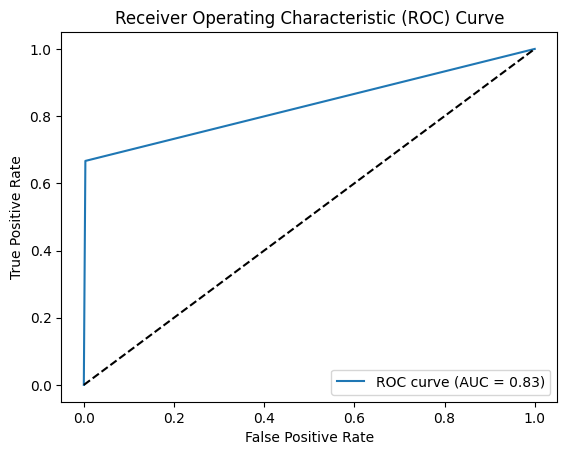

In [1597]:

import matplotlib.pyplot as plt

dfdata, incident, fl_df = getdata(dsbysite, 'LIM003', 24, StandardScaler(),'detrend',24,kpis_metrics,failure_metrics)  
#failure_metrics, kpis_metrics
#MedianScaler #StandardScaler
#lag = 4
#fl_df['Mean'] = fl_df['Mean'].shift(lag).fillna(method='bfill')

#########################################################

train_data,test_data = splitData(dfdata,0.7)

#########################################################
#model = fit_model(train_data,5, 0.02)
#n_estimators= 20,contamination = 0.01,max_samples = 0.75
model = fit_model_by_window(train_data, 20,0.01, 0.75, 168)

#########################################################
pred_data = predict(model,dfdata)
print(max(pred_data.index))

#########################################################
# Obtain outlier scores and true labels
outliers = flag_outliers(fl_df,'Mean')
outlier_scores = pred_data['outliers'] == -1 # outlier scores generated by the algorithm
true_labels = outliers['outlier']

print(outlier_scores.shape,true_labels.shape )
#true_labels = incident['incident']  # true labels for the data points (0: inliers, 1: outliers)

# Compute the FPR, TPR, and thresholds
fpr, tpr, thresholds = roc_curve(true_labels, outlier_scores)

# Calculate AUC
auc_score = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(auc_score))
plt.plot([0, 1], [0, 1], 'k--')  # diagonal line representing random classifier
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [1277]:
outlier_scores

datetime
2023-01-31 00:00:00    False
2023-01-31 01:00:00    False
2023-01-31 02:00:00    False
2023-01-31 03:00:00    False
2023-01-31 04:00:00    False
                       ...  
2023-03-20 19:00:00    False
2023-03-20 20:00:00    False
2023-03-20 21:00:00    False
2023-03-20 22:00:00    False
2023-03-20 23:00:00    False
Name: outliers, Length: 1176, dtype: bool

,Normal,Outlier
Normal,0.996564,0.003436
Outlier,0.333333,0.666667


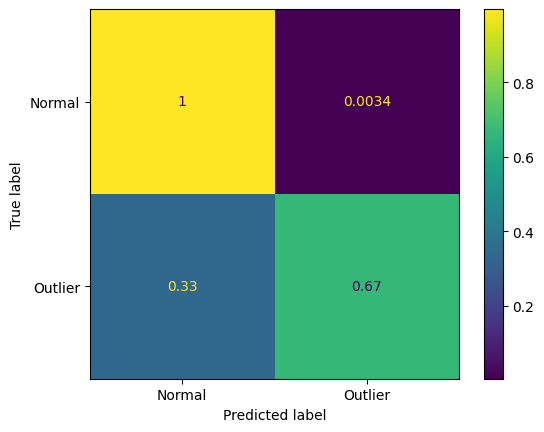

In [1607]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
labels = ['Normal','Outlier']
cm = confusion_matrix(true_labels.values,outlier_scores.values, normalize = "true")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= labels)
disp.plot()
pd.DataFrame(cm,columns=labels, index=labels)

(1176, 54)
(1176, 37)
34
2023-03-06 00:00:00
34
2023-03-06 00:00:00
(817,) (817,)


C:\Users\GeorgiosCh\AppData\Local\Temp\2\ipykernel_7184\411639071.py:28: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



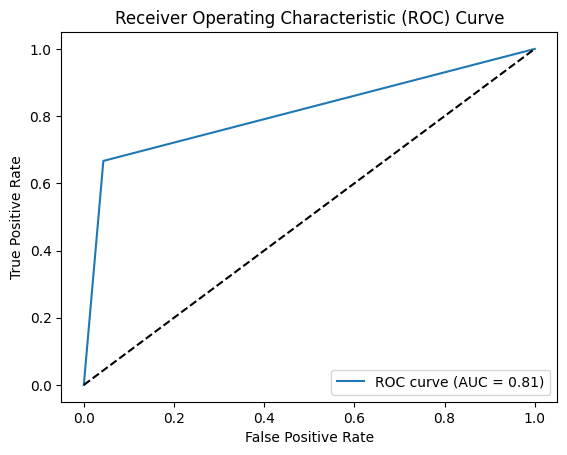

array([[0.95668317, 0.04331683],
       [0.33333333, 0.66666667]])

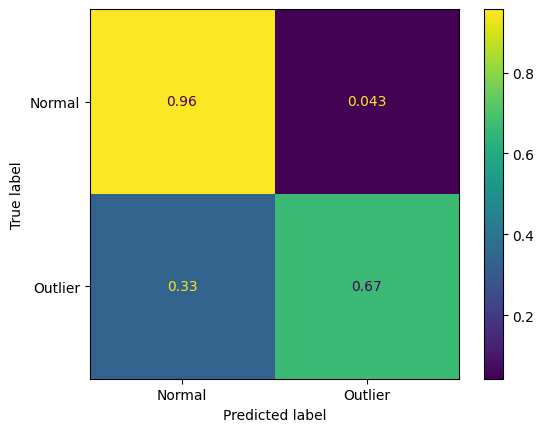

In [1621]:
import matplotlib.pyplot as plt

dfdata, incident, fl_df = getdata(dsbysite, 'LIM003', 24, StandardScaler(),'detrend',24,kpis_metrics,failure_metrics)  
#failure_metrics, kpis_metrics
#MedianScaler #StandardScaler
#lag = 4
#fl_df['Mean'] = fl_df['Mean'].shift(lag).fillna(method='bfill')

#########################################################

train_data,test_data = splitData(dfdata,0.7)
y_train,y_test = splitData(fl_df,0.7)

#########################################################
# create an instance of the LocalOutlierFactor class
model = LocalOutlierFactor(algorithm = 'auto', contamination=  0.05, n_neighbors=10) 
pred_data = model.fit_predict(train_data)

#########################################################
#pred_data = model.predict(dfdata)
#print(pred_data)

#########################################################
# Obtain outlier scores and true labels
true_outliers = flag_outliers(y_train,'Mean')
true_labels = true_outliers['outlier']

y_train['pred_outliers'] = pred_data
outlier_scores = (y_train['pred_outliers'] == -1) # outlier scores generated by the algorithm


print(outlier_scores.shape,true_labels.shape )
#true_labels = incident['incident']  # true labels for the data points (0: inliers, 1: outliers)

# Compute the FPR, TPR, and thresholds
fpr, tpr, thresholds = roc_curve(true_labels, outlier_scores)

# Calculate AUC
auc_score = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(auc_score))
plt.plot([0, 1], [0, 1], 'k--')  # diagonal line representing random classifier
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
labels = ['Normal','Outlier']
cm = confusion_matrix(true_labels.values,outlier_scores.values, normalize = "true")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= labels)
disp.plot()
cm#pd.DataFrame(cm,columns=labels, index=labels)

### Tuning Hyperparameter
#### IsolationForest

In [1253]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import numpy as np
import time

dfdata, incident, fl_df = getdata(dsbysite, 'LIM003', 24, StandardScaler(),'detrend',24,kpis_metrics,failure_metrics)  
#failure_metrics, kpis_metrics

fl_df.shape
X_train,X_test = splitData(dfdata,0.7)
X_train,X_test = X_train.values,X_test.values

y_train,y_test = splitData(fl_df,0.7)
y_train,y_test = y_train['Mean'].values,y_test['Mean'].values

y_train,y_test = splitData(incident,0.7)
y_train,y_test = y_train.values,y_test.values


models = [IsolationForest(),LocalOutlierFactor(novelty=True)]
model_names = ['IsolationForest','LocalOutlierFactor']

results = []

for i, m in enumerate(models):
    tstart = time.time()
    model = m.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    # Compute error
    train_rmse = mean_squared_error(y_train, y_pred_train)**0.5
    test_rmse = mean_squared_error(y_test, y_pred_test)**0.5
    r2 = r2_score(y_test,y_pred_test)
    tend = time.time()
    rs = [train_rmse,test_rmse,r2,tend - tstart]
    results.append(rs)
    
columns=["train_rmse","test_rmse","r2","seconds"]
pd.DataFrame(results, columns=columns, index=model_names)

(1176, 54)
(1176, 37)
34
2023-03-06 00:00:00
34
2023-03-06 00:00:00
34
2023-03-06 00:00:00


,train_rmse,test_rmse,r2,seconds
IsolationForest,1.0,1.00417,-362.011173,0.358261
LocalOutlierFactor,1.0,1.00417,-362.011173,0.266305


In [1294]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error, f1_score

dfdata, incident, fl_df = getdata(dsbysite, 'LIM003', 24, StandardScaler(),'detrend',24,kpis_metrics,failure_metrics)  
#failure_metrics, kpis_metrics

fl_df.shape
X_train,X_test = splitData(dfdata,0.7)
X_train,X_test = X_train.values,X_test.values

y_train,y_test = splitData(fl_df,0.7)
#y_train,y_test = y_train['Mean'].values,y_test['Mean'].values

# Obtain outlier scores and true labels
y_train = flag_outliers(y_train,'Mean')
y_train = y_train['outlier'].values
y_train
#y_train,y_test = splitData(incident,0.7)
#y_train,y_test = y_train.values,y_test.values


# create an instance of the IsolationForest class
model = IsolationForest() 

# define the parameter grid for hyperparameter tuning
param_grid = {'n_estimators': [5, 10, 20,30]
              ,'max_samples': [0.5, 0.75, 1.0]
              , 'contamination': [0.01,0.02,0.05, 0.1, 0.15]}

# define a custom scorer function
def custom_fscore(model, X, y):
    y_pred = model.predict(X) #outliers
    y_pred = (y_pred == -1) 
    print(y_pred.shape)
    fscore = f1_score(y_train, y_pred, pos_label=-1, zero_division=1) 
    return fscore

# define a custom scorer function
def custom_scorer(model, X, y):
    y_pred = -model.decision_function(X)
    return roc_auc_score(y_true, y_pred)
  
#custom_scorer = make_scorer(custom_scorer, greater_is_better=False, needs_proba=False, needs_threshold=False)

# create a GridSearchCV object
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='r2')
#grid_search = GridSearchCV(model, param_grid, cv=5, scoring=custom_fscore)

# fit the GridSearchCV object to the data
grid_search.fit(X_train,y_train)

# print the best hyperparameters and the corresponding score
print("Best hyperparameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

(1176, 54)
(1176, 37)
34
2023-03-06 00:00:00
34
2023-03-06 00:00:00
Best hyperparameters: {'contamination': 0.01, 'max_samples': 1.0, 'n_estimators': 20}
Best score: -54.3383022774327


### Tuning Hyperparameter
#### LocalOutlierFactor

In [664]:
dfdata, incident, lable_df = getdata(dsbysite, 'LIM003', 24, StandardScaler(),'detrend',24,kpis_metrics,failure_metrics)  
#failure_metrics, kpis_metrics

fl_df.shape
X_train,X_test = splitData(dfdata,0.7)
X_train,X_test = X_train.values,X_test.values

lag = 5
lable_df['Mean'] = lable_df['Mean'].shift(lag).fillna(method='bfill')
y_train,y_test = splitData(lable_df,0.7)
y_train,y_test = y_train['Mean'].values,y_test['Mean'].values


#y_train,y_test = splitData(incident,0.7)
#y_train,y_test = y_train.values,y_test.values

#dfdata = rollingAvg(dfdata,24)
#print('Missing Values {}'.format(len(getMissingValues(dfdata))))
#print('Missing Values {}'.format(len(getMissingValues(dfdata_label))))

##############################################################

# create an instance of the LocalOutlierFactor class
model = LocalOutlierFactor() 

# define the parameter grid for hyperparameter tuning
param_grid = {'n_neighbors': [5, 10, 20, 30], 
              'contamination': [0.02,0.05, 0.1, 0.15],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'novelty' : [True]}


# define a custom scorer function
def custom_scorer(model, X, y_true):
    y_pred = -model.decision_function(X)
    return mean_squared_error(y_true, y_pred)

# define a custom scorer function
def custom_fscore(model, X, y = None):
    y_pred = model.predict(X) #outliers
    fscore = f1_score(np.ones(len(y_pred)), y_pred, pos_label=-1, zero_division=1)
    return fscore

#custom_scorer = make_scorer(custom_scorer, greater_is_better=False, needs_proba=False, needs_threshold=False)

# create a GridSearchCV object
grid_search = GridSearchCV(model, param_grid, cv=5, scoring=custom_fscore)

# fit the GridSearchCV object to the data
grid_search.fit(x, y)

#
#neg_mean_squared_error
#"neg_median_absolute_error",
#"r2",
#"neg_mean_absolute_error",
#"neg_mean_absolute_percentage_error",
#"neg_mean_squared_log_error", neg_mean_squared_error
#"neg_root_mean_squared_error",


# print the best hyperparameters and the corresponding score
print("Best hyperparameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

(1176, 64)
(1176, 46)
Best hyperparameters: {'algorithm': 'auto', 'contamination': 0.02, 'n_neighbors': 30, 'novelty': True}
Best score: 0.2


### TimeSeriesSplit 

### F1-score
also known as the F-score, is a metric used to evaluate the performance of a binary classification model. It combines precision and recall of the model into a single score.

- The formula for F1-score is:
    f_score = f1_score(y_true, y_pred, zero_division=1)
- F1-score ranges from 0 to 1, with a higher score indicating better performance. An F1-score of 1 indicates perfect precision and recall, while an F1-score of 0 indicates poor performance.

F1-score is particularly useful when the classes in the dataset are imbalanced, meaning that there are significantly more samples of one class than the other. In such cases, accuracy may not be a good metric to use, as it can be biased towards the majority class. F1-score provides a better measure of the model's performance by taking into account both precision and recall.

#### Average Path Length (APL) 
is a measure of the average number of edges traversed by an instance in the binary tree that is constructed during the training process of the Isolation Forest model. The APL is used as a measure of the anomaly score for each instance in the data.

(1176, 54)
(1176, 37)
Window size of 24.0 hours
"Average path length (APL)    0.999499
F1 Score                      0.968559
AUC Score                     0.641064
dtype: float64
Number of Initial E-RAB Setup Attempt(unit)


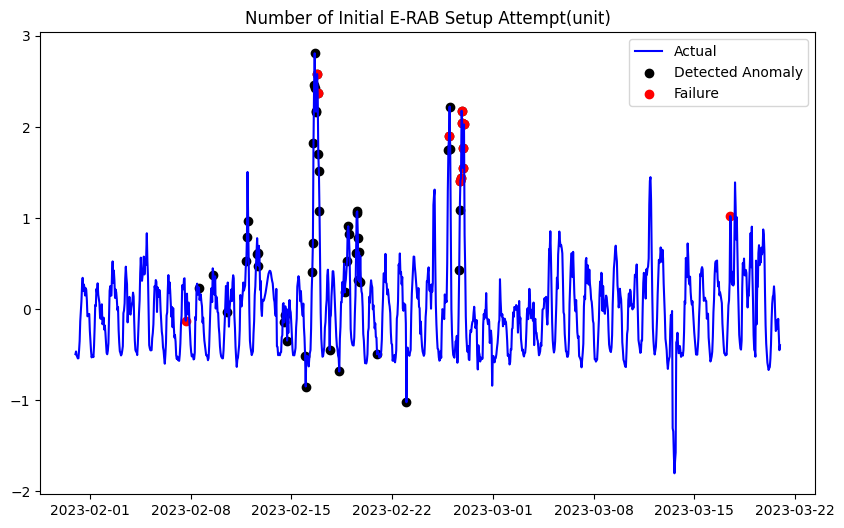

,Normal,Outlier
0,0.961340,0.038660
1,0.166667,0.833333


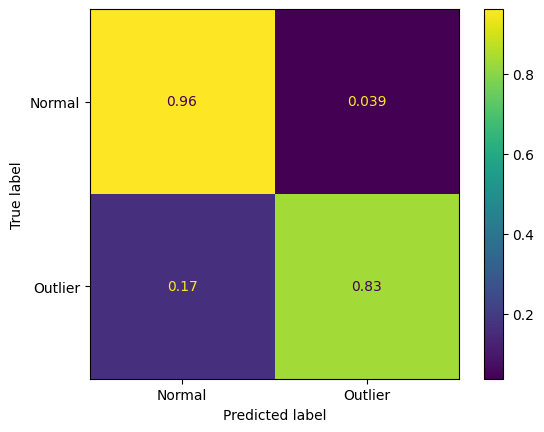

In [1631]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import IsolationForest
from sklearn.metrics import f1_score
import numpy as np

dfdata, incident, lable_df = getdata(dsbysite, 'LIM003', 24, StandardScaler(),'detrend',24,kpis_metrics,failure_metrics_times)  
#failure_metrics, kpis_metrics
#MedianScaler #StandardScaler
lag = 0
#lable_df['Mean'] = lable_df['Mean'].shift(lag).fillna(method='bfill')

# create an instance of the IsolationForest class
model = IsolationForest(contamination = 0.02, n_estimators = 20, max_samples= 0.75)

# define the time-series cross-validation iterator
n_splits = 49
print('Window size of {} hours'.format(len(dfdata.index)/n_splits))
cv = TimeSeriesSplit(n_splits=6)

# iterate over the folds and compute the F1 score for each fold
scores = []

# Create a new DataFrame to stre the prediction values
pred = pd.DataFrame({'outlier': np.ones(len(dfdata.index))}, index=dfdata.index)

for i, (train_idx, test_idx) in enumerate(cv.split(dfdata)):
    
    # Adjust the test index to include the desired lag
    test_idx = test_idx[test_idx >= (train_idx[-1] + lag)]
    #print(adjusted_test_idx)
    
    X_train, X_test = dfdata.iloc[train_idx], dfdata.iloc[test_idx]
    y_train, y_test = lable_df.iloc[train_idx], lable_df.iloc[test_idx]

    #print("Number of Observation {}".format(len(X_train.index)))

    # fit the model to the training data
    model.fit(X_train.values,y_train.values)

    # predict the labels for the test data
    y_pred = model.predict(X_test.values) #outliers
    
    pred.iloc[test_idx, 0] = y_pred
    
    #predictions.iloc[test_idx]['predictions'] = y_pred
    #predictions.extend(y_pred)
 
    #########################################################
    y_pred = (y_pred == -1) # outlier scores generated by the algorithm
    # Obtain outlier scores and true labels
    y_test = flag_outliers(y_test,'Mean')
    y_test = y_test['outlier'].values
    #true_labels = incident['incident']  # true labels for the data points (0: inliers, 1: outliers)
    #print(y_pred, y_test)
    
    # Predict the outliers using the trained model
    X_scores = -model.decision_function(X_test.values)
    
    # compute the average path length (APL) for each instance in the data
    X_scores /= model.max_samples_
    X_scores = np.exp(X_scores.mean())
    #print("Average path length (APL):", X_scores)
    
    # compute the F1 score for the test data
    fscore = f1_score(y_test, y_pred, pos_label=False, zero_division=1) #np.ones(len(y_pred))
    #print("F1 Score:", fscore)
    
    # Compute the FPR, TPR, and thresholds
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)

    # Calculate AUC
    auc_score = auc(fpr, tpr)
    #print("AUC Score:", auc_score)
    
    scores.append([X_scores,fscore,auc_score])
    

# compute the mean score across the folds
mean_score = pd.DataFrame(scores, columns=['"Average path length (APL)','F1 Score','AUC Score'])
print(mean_score.mean())

    
## select the top
col = df.sort_values('pvalue_lag5')['var1'].head(1).values
col = dfdata.columns[5]
print(col)
plot_results(dfdata,fl_df,pred,col)
plot_matric(fl_df,pred)

In [1542]:
def plot_results(df,fl_df,pred, col):
    # Obtain outlier scores and true labels
    failures = flag_outliers(fl_df,'Mean')
    failures = df.loc[failures['outlier']==True, col] #anomaly

    # Create an array indicating the anomaly points
    outliers = df.loc[pred['outlier'] == -1, col] #anomaly

    fig, ax = plt.subplots(figsize=(10,6))
    ax.plot(df.index, dfdata[col], color='blue', label = 'Actual')
    ax.scatter(outliers.index,outliers, color='black', label = 'Detected Anomaly')
    ax.scatter(failures.index,failures, color='red', label = 'Failure')
    plt.title(col)
    plt.legend()
    plt.show();

[[0.96134021 0.03865979]
 [0.16666667 0.83333333]]


,Normal,Outlier
0,0.961340,0.038660
1,0.166667,0.833333


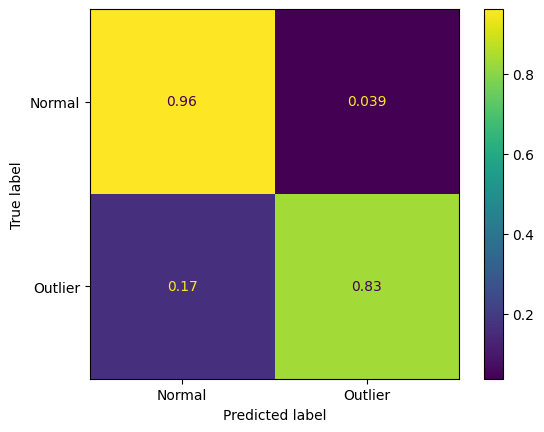

In [1632]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
def plot_matric(fl_df,pred):
    # Obtain outlier scores and true labels
    labels = ['Normal','Outlier']
    failures = flag_outliers(fl_df,'Mean')
    
    # Create an array indicating the anomaly points
    outliers = (pred['outlier'] == -1) #anomaly
    
    cm = confusion_matrix(failures['outlier'].values,outliers.values, normalize = "true")
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= labels)
    disp.plot()
    print(cm)
    return pd.DataFrame(cm,columns=labels)
    
plot_matric(fl_df,pred)


In [1630]:
len(dfdata.index)/24

49.0

In [1267]:
dfdata = dsbysite.loc[dsbysite['SiteCode'] == 'LIM003'].copy()
dfdata = dfdata.drop('SiteCode', axis=1)
dfdata_label = dfdata['incident']
dfdata_label = dfdata_label.reset_index().fillna(False)
dfdata = dfdata.drop('incident', axis=1)
dfdata = fillNa(dfdata,24)

dfdata = remove_low_variance_features(dfdata,0.05)
print(dfdata.shape)
dfdata = remove_high_corr_features(dfdata,0.999)
print(dfdata.shape)

dfdata = normalizedValues(dfdata,StandardScaler()) 

# create an instance of the IsolationForest class
model = LocalOutlierFactor(algorithm = 'auto', contamination=  0.02, n_neighbors=5) 

# define the time-series cross-validation iterator
cv = TimeSeriesSplit(n_splits=168)

# iterate over the folds and compute the F1 score for each fold
scores = []
for i, (train_idx, test_idx) in enumerate(cv.split(dfdata)):
    #print(f"++++++++++++++++++ Fold {i}: ++++++++++++++++++++++++")
    # split the data into training and test sets
    X_train, X_test = dfdata.iloc[train_idx], dfdata.iloc[test_idx]

    # fit the model to the training data
    # and predict the labels for the test data
    y_pred = model.fit_predict(X_test) #outliers
            
    # compute the F1 score for the test data
    score = f1_score(np.ones(len(y_pred)), y_pred, pos_label=-1, zero_division=1)
    #print("F1 Score:", score)
    
    scores.append(score)
    
# compute the mean F1 score across the folds
mean_score = np.mean(scores)
print("Mean F1 Score: {:.2f}".format( mean_score))

(1176, 64)
(1176, 46)
Mean F1 Score: 0.00
